# Arrhythmia Data Dive

## Dataset is from MITBIH Arrhythmia Database - https://www.physionet.org/content/mitdb/1.0.0/

## Importing Packages 

In [2]:
import os
import wfdb as wf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout,MaxPooling1D,GlobalAveragePooling1D
from tensorflow.keras import Model, layers,Sequential,regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
import itertools
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from sklearn.model_selection import KFold
import itertools
from sklearn.metrics import confusion_matrix
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

C:\Users\sreem\anaconda3\Lib\site-packages\tensorflow\python\client\session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


## Data Extraction

In [3]:
arrhythmia_data = r'C:\Users\sreem\Downloads\mit-bih-arrhythmia-database-1.0.0\mit-bih-arrhythmia-database-1.0.0'
datafiles = os.listdir(arrhythmia_data)
print(datafiles)

['100.atr', '100.dat', '100.hea', '100.xws', '101.atr', '101.dat', '101.hea', '101.xws', '102-0.atr', '102.atr', '102.dat', '102.hea', '102.xws', '103.atr', '103.dat', '103.hea', '103.xws', '104.atr', '104.dat', '104.hea', '104.xws', '105.atr', '105.dat', '105.hea', '105.xws', '106.atr', '106.dat', '106.hea', '106.xws', '107.atr', '107.dat', '107.hea', '107.xws', '108.atr', '108.at_', '108.dat', '108.hea', '108.xws', '109.atr', '109.dat', '109.hea', '109.xws', '111.atr', '111.dat', '111.hea', '111.xws', '112.atr', '112.dat', '112.hea', '112.xws', '113.atr', '113.dat', '113.hea', '113.xws', '114.atr', '114.dat', '114.hea', '114.xws', '115.atr', '115.dat', '115.hea', '115.xws', '116.atr', '116.dat', '116.hea', '116.xws', '117.atr', '117.at_', '117.dat', '117.hea', '117.xws', '118.atr', '118.dat', '118.hea', '118.xws', '119.atr', '119.at_', '119.dat', '119.hea', '119.xws', '121.atr', '121.dat', '121.hea', '121.xws', '122.atr', '122.dat', '122.hea', '122.xws', '123.atr', '123.dat', '123.he

In [4]:
dat_filedata = [file for file in os.listdir(arrhythmia_data) if file.endswith('.dat')]
data_records = sorted([os.path.splitext(file)[0] for file in dat_filedata])
print('Total record files:', len(data_records))
for record_id in data_records:
    record_pathdata = os.path.join(arrhythmia_data, record_id)
    record_data, record_information = wf.rdsamp(record_pathdata)  
    annotation_data = wf.rdann(record_pathdata, 'atr')
    print(f'\nRecord ID: {record_id}')
    print('Sampling frequency per second per channel:', record_information.get('fs'))
    print('Shape of Data:', record_data.shape)
    print('Annotations:', len(annotation_data.num))

Total record files: 48

Record ID: 100
Sampling frequency per second per channel: 360
Shape of Data: (650000, 2)
Annotations: 2274

Record ID: 101
Sampling frequency per second per channel: 360
Shape of Data: (650000, 2)
Annotations: 1874

Record ID: 102
Sampling frequency per second per channel: 360
Shape of Data: (650000, 2)
Annotations: 2192

Record ID: 103
Sampling frequency per second per channel: 360
Shape of Data: (650000, 2)
Annotations: 2091

Record ID: 104
Sampling frequency per second per channel: 360
Shape of Data: (650000, 2)
Annotations: 2311

Record ID: 105
Sampling frequency per second per channel: 360
Shape of Data: (650000, 2)
Annotations: 2691

Record ID: 106
Sampling frequency per second per channel: 360
Shape of Data: (650000, 2)
Annotations: 2098

Record ID: 107
Sampling frequency per second per channel: 360
Shape of Data: (650000, 2)
Annotations: 2140

Record ID: 108
Sampling frequency per second per channel: 360
Shape of Data: (650000, 2)
Annotations: 1824

Reco

In [5]:
hea_filedata = [file for file in os.listdir(arrhythmia_data) if file.endswith('.hea')]
data_records = [os.path.splitext(file)[0] for file in hea_filedata]
print('Total record files:', len(data_records))
for record_id in data_records:
    hea_pathdata = os.path.join(arrhythmia_data, f'{record_id}.hea')
    with open(hea_pathdata, 'r') as hea_filedata:
        hea_contentdata = hea_filedata.read()
    print(f'Record Id: {record_id}')
    print('Content of .hea file:')
    print(hea_contentdata)

Total record files: 48
Record Id: 100
Content of .hea file:
100 2 360 650000
100.dat 212 200 11 1024 995 -22131 0 MLII
100.dat 212 200 11 1024 1011 20052 0 V5
# 69 M 1085 1629 x1
# Aldomet, Inderal

Record Id: 101
Content of .hea file:
101 2 360 650000
101.dat 212 200 11 1024 955 29832 0 MLII
101.dat 212 200 11 1024 992 19589 0 V1
# 75 F 1011 654 x1
# Diapres

Record Id: 102
Content of .hea file:
102 2 360 650000
102.dat 212 200 11 1024 984 -28574 0 V5
102.dat 212 200 11 1024 1025 13743 0 V2
# 84 F 1525 167 x1
# Digoxin
# The rhythm is paced with a demand pacemaker.  The PVCs are multiform.

Record Id: 103
Content of .hea file:
103 2 360 650000
103.dat 212 200 11 1024 949 11457 0 MLII
103.dat 212 200 11 1024 1034 -31983 0 V2
# -1 M 742 654 x1
# Diapres, Xyloprim

Record Id: 104
Content of .hea file:
104 2 360 650000
104.dat 212 200 11 1024 994 -14371 0 V5
104.dat 212 200 11 1024 1064 17572 0 V2
# 66 F 1567 694 x1
# Digoxin, Pronestyl
# The rate of paced rhythm is close to that of the u

## Exploring Raw Data

### Defining Beat Type

In [6]:
def beat_types():
    beat = ['N', 'L', 'R', 'B', 'A',
            'a', 'J', 'S', 'V', 'r',
            'F', 'e', 'j', 'n', 'E',
            '/', 'f', 'Q', '?']

    return beat
beattype = beat_types()
print(beattype)

['N', 'L', 'R', 'B', 'A', 'a', 'J', 'S', 'V', 'r', 'F', 'e', 'j', 'n', 'E', '/', 'f', 'Q', '?']


### Function to Extract Sample Positions for Beat Types

In [7]:
def beat_ann_array(ann):
    beattype = beat_types()
    arr_ids = np.in1d(annotation_data.symbol, beattype)
    ann_beat = annotation_data.sample[arr_ids]
    return ann_beat

beat_ann_result = beat_ann_array(annotation_data)
print(beat_ann_result)

[   135    366    606 ... 649292 649536 649772]


### Physical Signal Data

In [8]:
for record_id in data_records:
    record_path = os.path.join(arrhythmia_data, record_id)
    signals, record_information = wf.rdsamp(record_path)  

    # Access signals Data
    p_signals = signals[:, 1]
    p_signals = signals[:, 0] 

    print(f'\nRecord ID: {record_id}')
    print('Physical Signals:', p_signals)


Record ID: 100
Physical Signals: [-0.145 -0.145 -0.145 ... -0.675 -0.765 -1.28 ]

Record ID: 101
Physical Signals: [-0.345 -0.345 -0.345 ... -0.295 -0.29   0.   ]

Record ID: 102
Physical Signals: [-0.2   -0.2   -0.2   ... -0.17  -0.195  0.   ]

Record ID: 103
Physical Signals: [-0.375 -0.375 -0.375 ... -0.235 -0.245  0.   ]

Record ID: 104
Physical Signals: [-0.15  -0.15  -0.15  ... -0.065 -0.06   0.   ]

Record ID: 105
Physical Signals: [-0.445 -0.445 -0.445 ...  0.59   0.76   1.28 ]

Record ID: 106
Physical Signals: [-0.31  -0.31  -0.31  ...  0.635  0.265  0.   ]

Record ID: 107
Physical Signals: [-2.045 -2.045 -2.045 ... -0.645 -0.635  0.   ]

Record ID: 108
Physical Signals: [-0.125 -0.125 -0.125 ... -0.01   0.04   0.   ]

Record ID: 109
Physical Signals: [ 0.175  0.175  0.175 ... -0.92  -0.91  -1.28 ]

Record ID: 111
Physical Signals: [-0.035 -0.035 -0.035 ...  0.155  0.2    0.   ]

Record ID: 112
Physical Signals: [-0.75  -0.75  -0.75  ... -0.825 -0.81  -1.28 ]

Record ID: 113


### Physical Signal Name

In [9]:
for record_id in data_records:
    record_pathdata = os.path.join(arrhythmia_data, record_id)
    signals, record_information = wf.rdsamp(record_pathdata)
    signal_name = record_information['sig_name']
    print(f'\nRecord ID : {record_id}')
    print('Signal Names:', signal_name)


Record ID : 100
Signal Names: ['MLII', 'V5']

Record ID : 101
Signal Names: ['MLII', 'V1']

Record ID : 102
Signal Names: ['V5', 'V2']

Record ID : 103
Signal Names: ['MLII', 'V2']

Record ID : 104
Signal Names: ['V5', 'V2']

Record ID : 105
Signal Names: ['MLII', 'V1']

Record ID : 106
Signal Names: ['MLII', 'V1']

Record ID : 107
Signal Names: ['MLII', 'V1']

Record ID : 108
Signal Names: ['MLII', 'V1']

Record ID : 109
Signal Names: ['MLII', 'V1']

Record ID : 111
Signal Names: ['MLII', 'V1']

Record ID : 112
Signal Names: ['MLII', 'V1']

Record ID : 113
Signal Names: ['MLII', 'V1']

Record ID : 114
Signal Names: ['V5', 'MLII']

Record ID : 115
Signal Names: ['MLII', 'V1']

Record ID : 116
Signal Names: ['MLII', 'V1']

Record ID : 117
Signal Names: ['MLII', 'V2']

Record ID : 118
Signal Names: ['MLII', 'V1']

Record ID : 119
Signal Names: ['MLII', 'V1']

Record ID : 121
Signal Names: ['MLII', 'V1']

Record ID : 122
Signal Names: ['MLII', 'V1']

Record ID : 123
Signal Names: ['MLII'

### Visualizing ECG Signals


Record ID: 100
Annotations: 2274


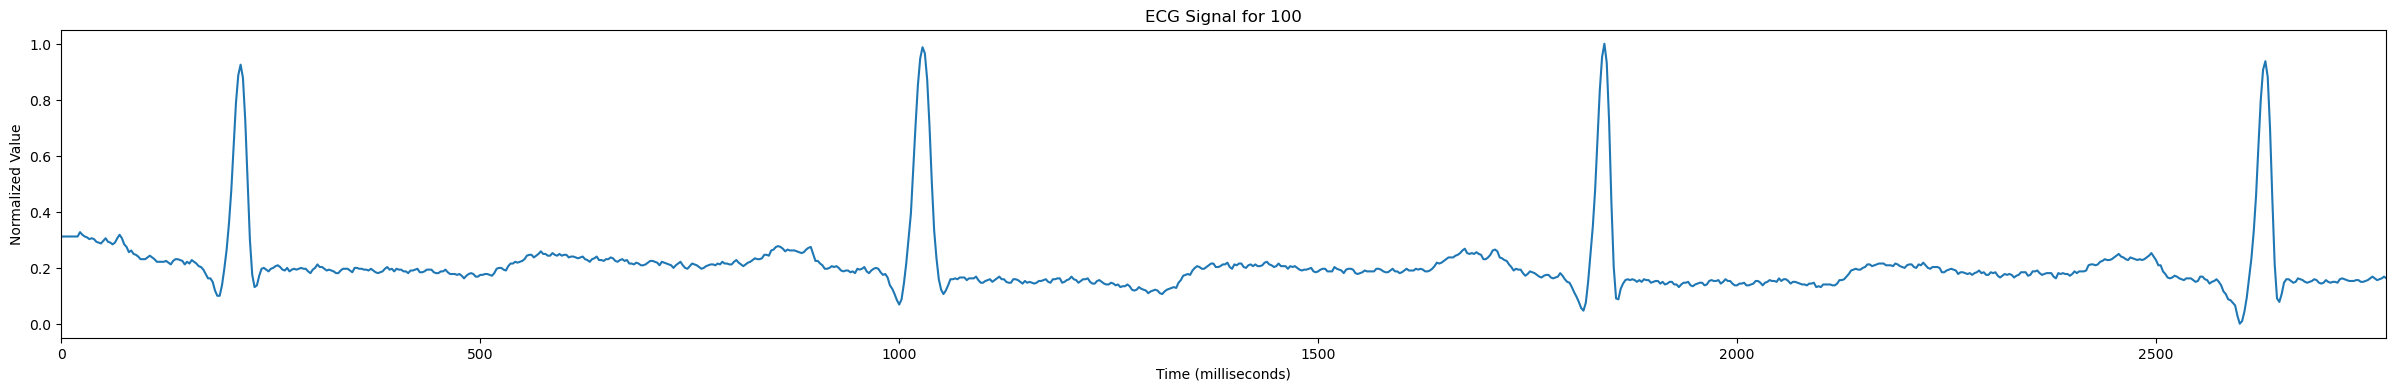


Record ID: 101
Annotations: 1874


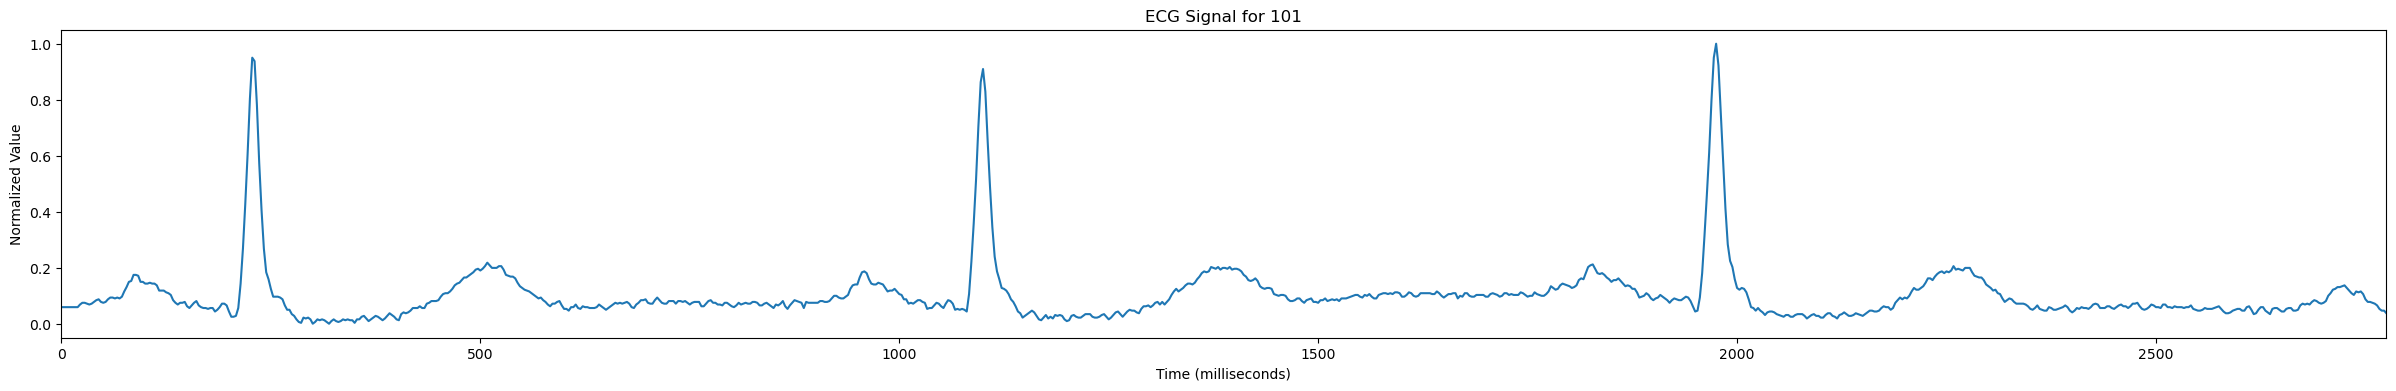


Record ID: 102
Annotations: 2192


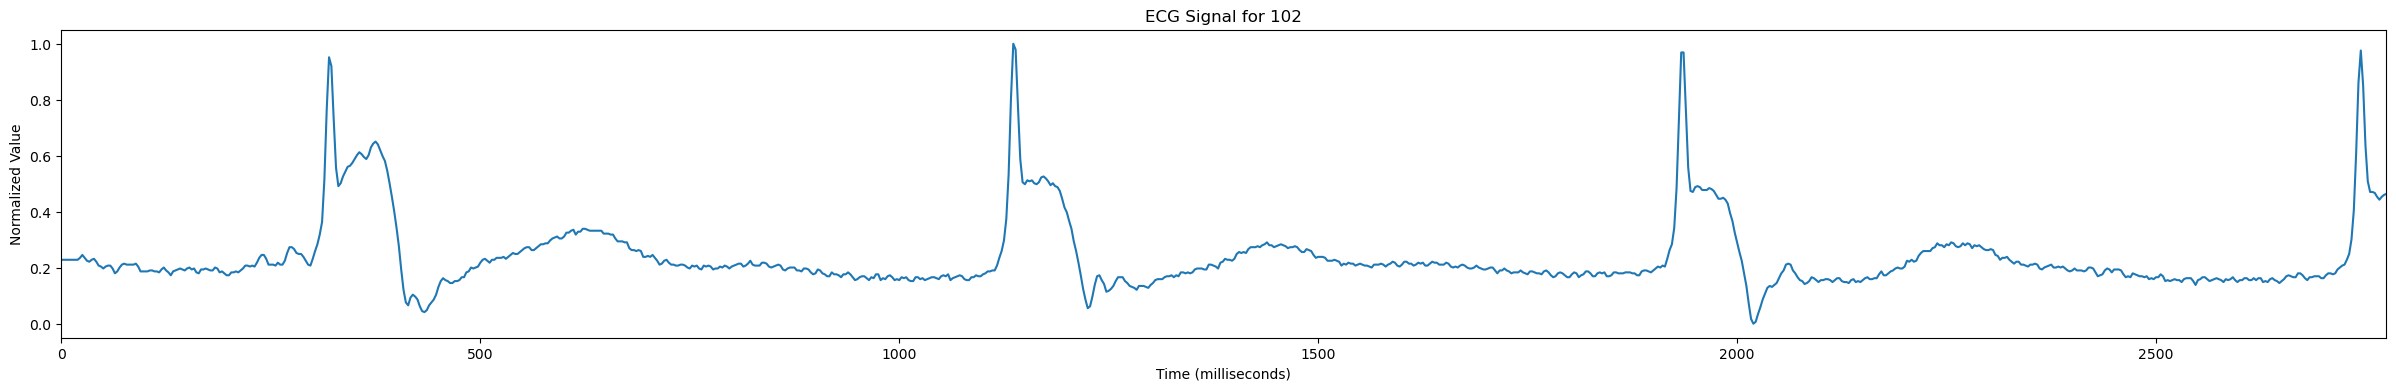


Record ID: 103
Annotations: 2091


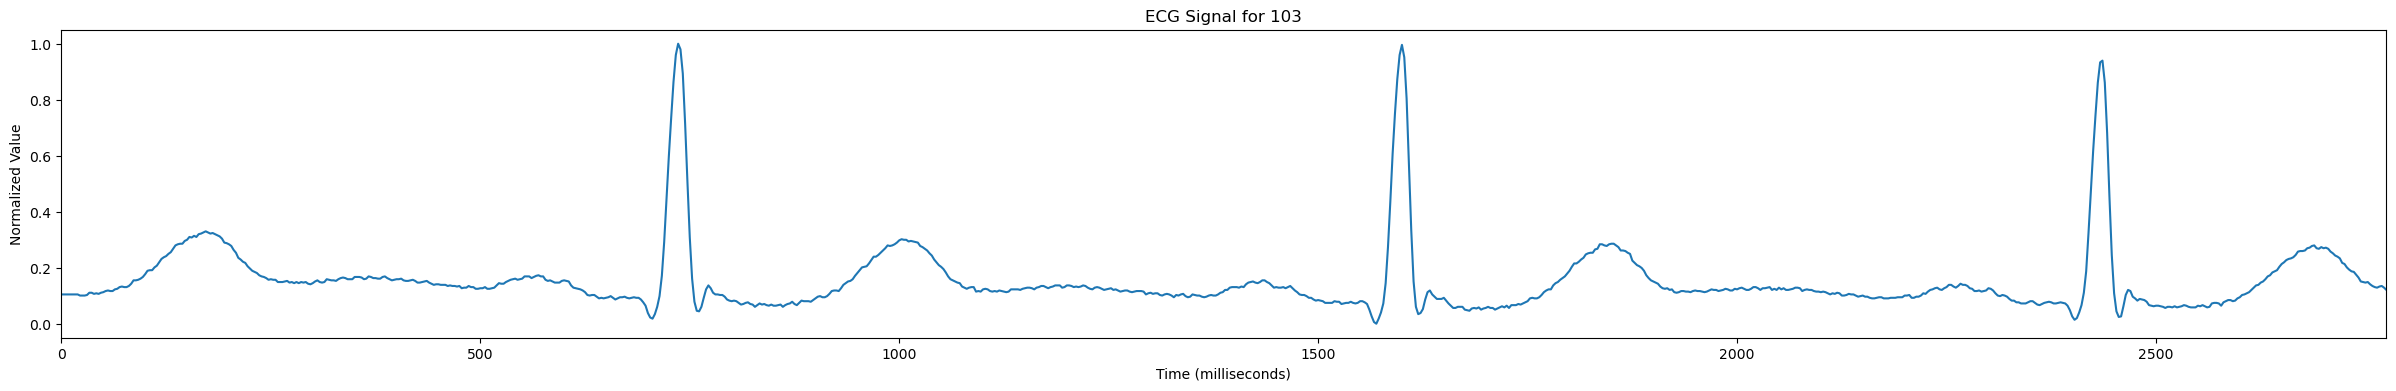


Record ID: 104
Annotations: 2311


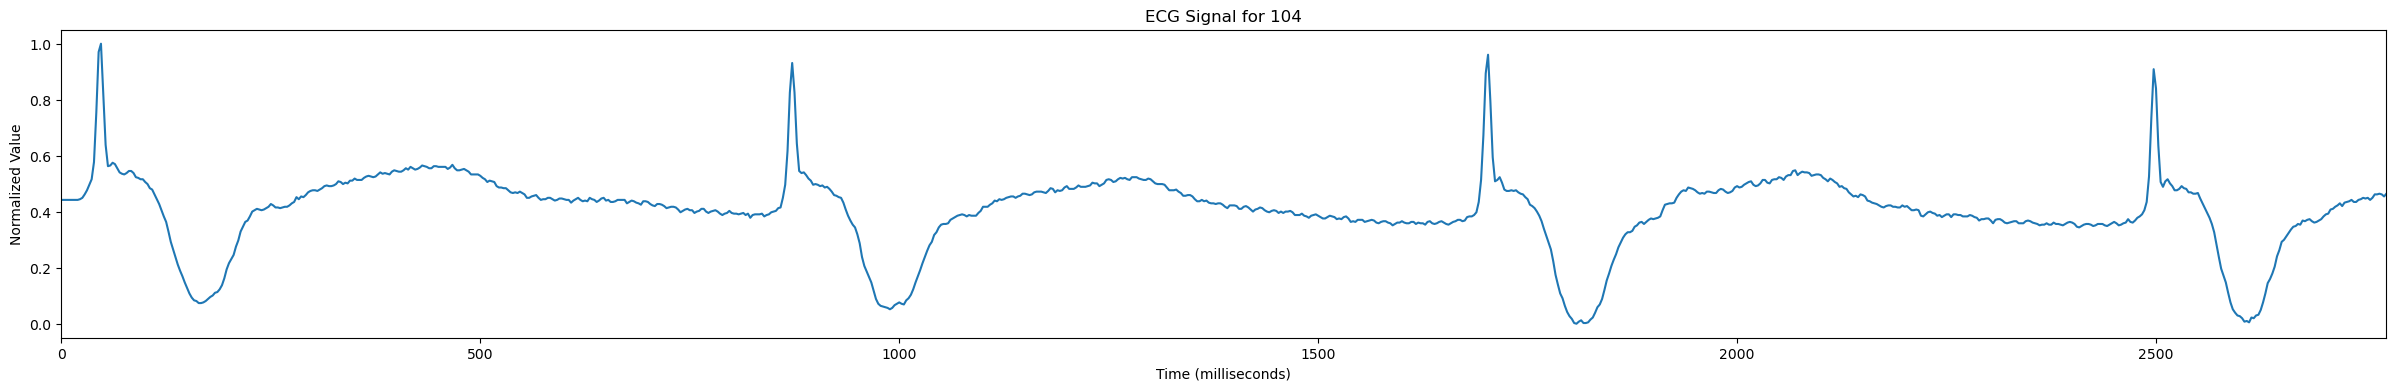


Record ID: 105
Annotations: 2691


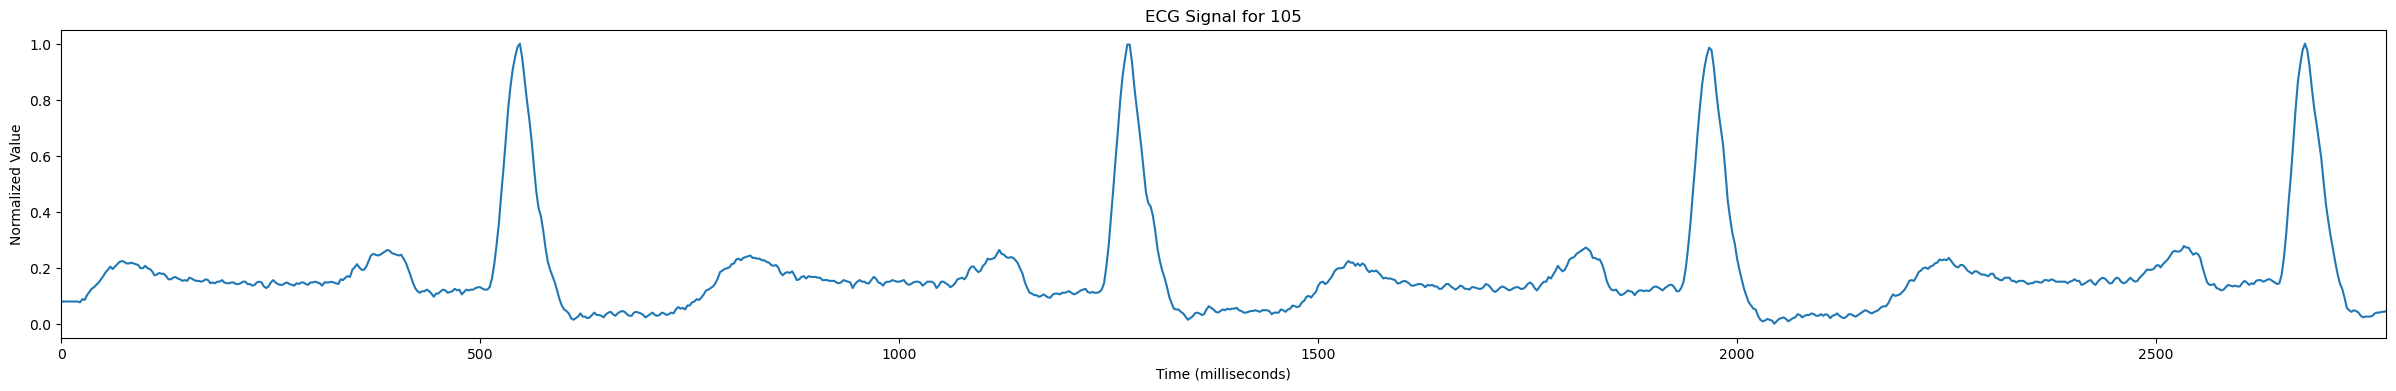


Record ID: 106
Annotations: 2098


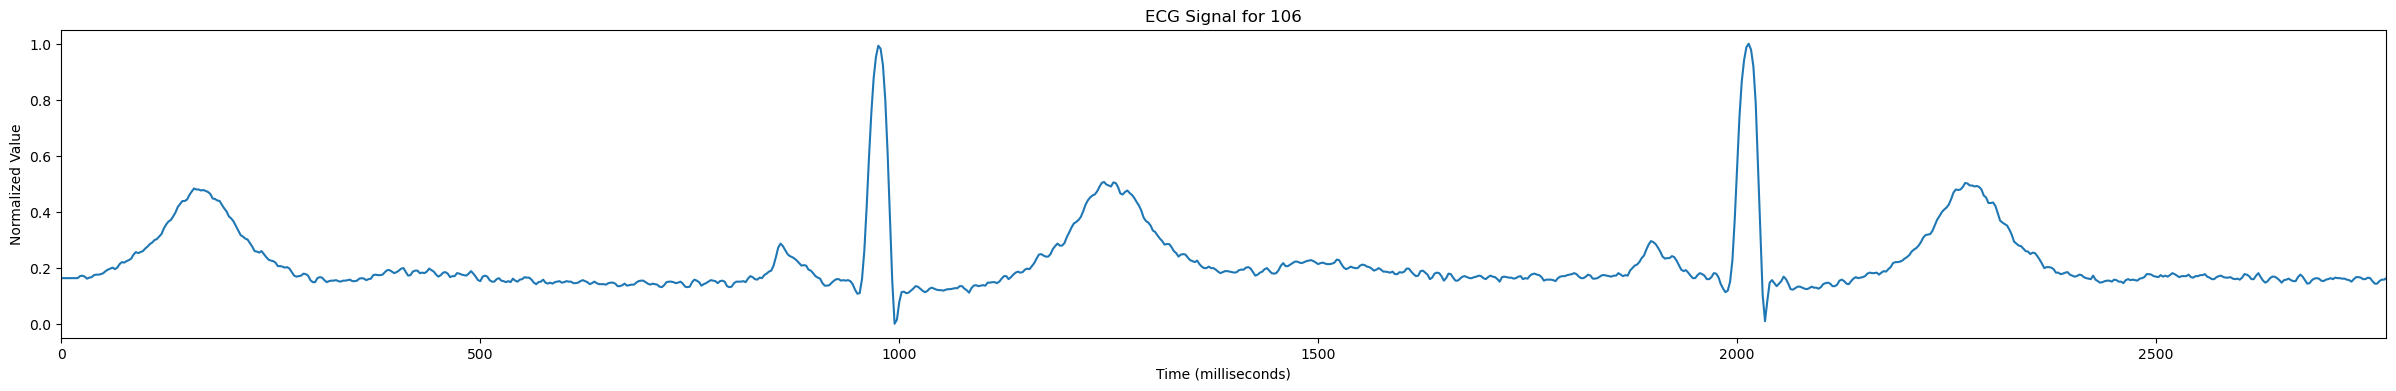


Record ID: 107
Annotations: 2140


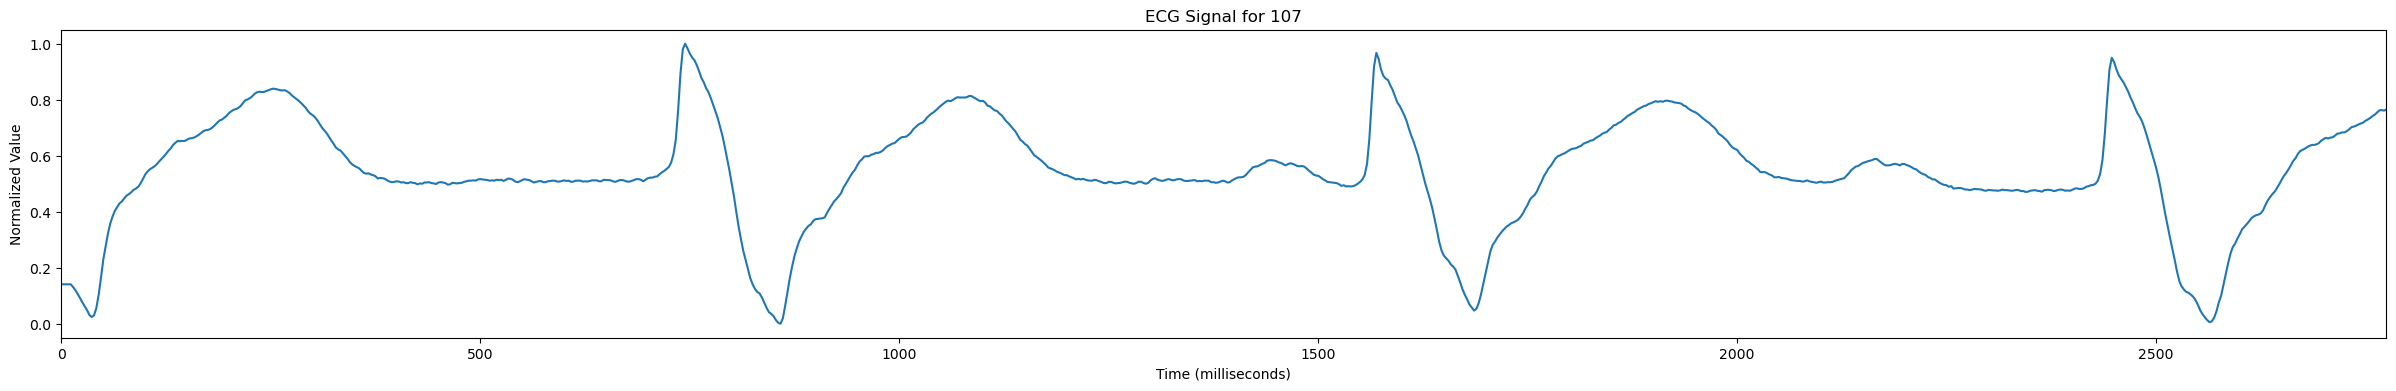


Record ID: 108
Annotations: 1824


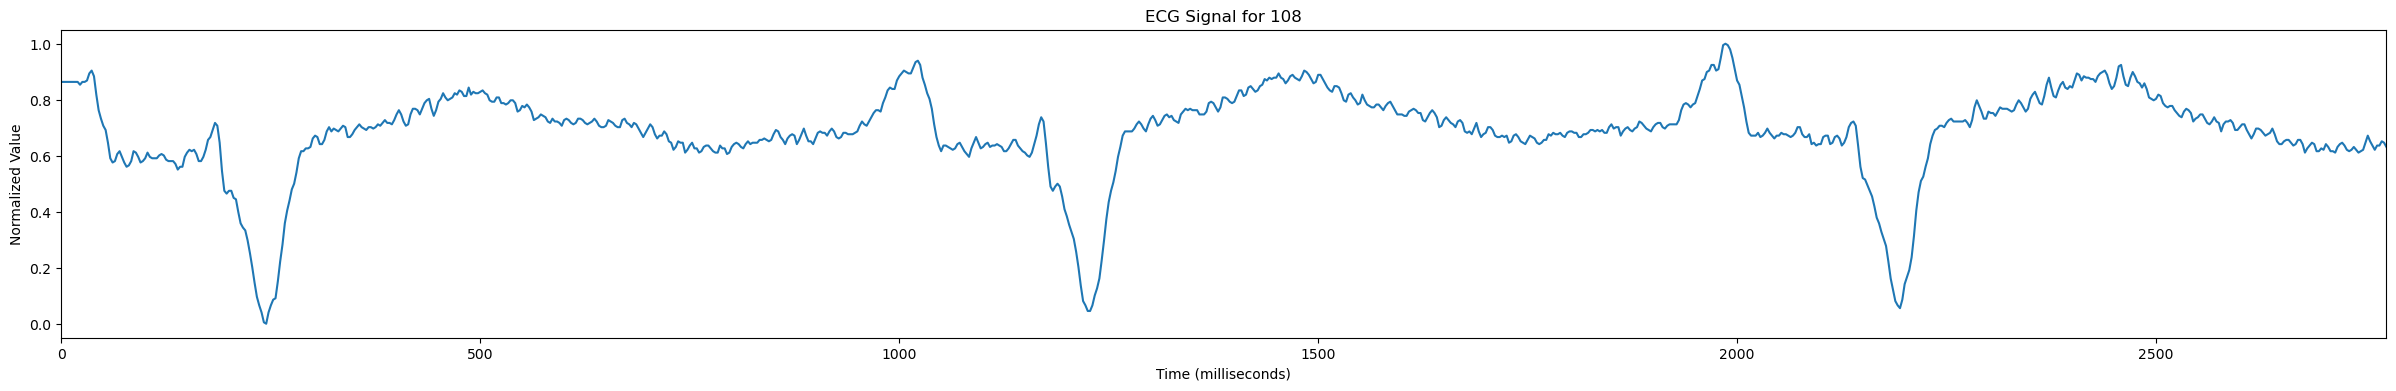


Record ID: 109
Annotations: 2535


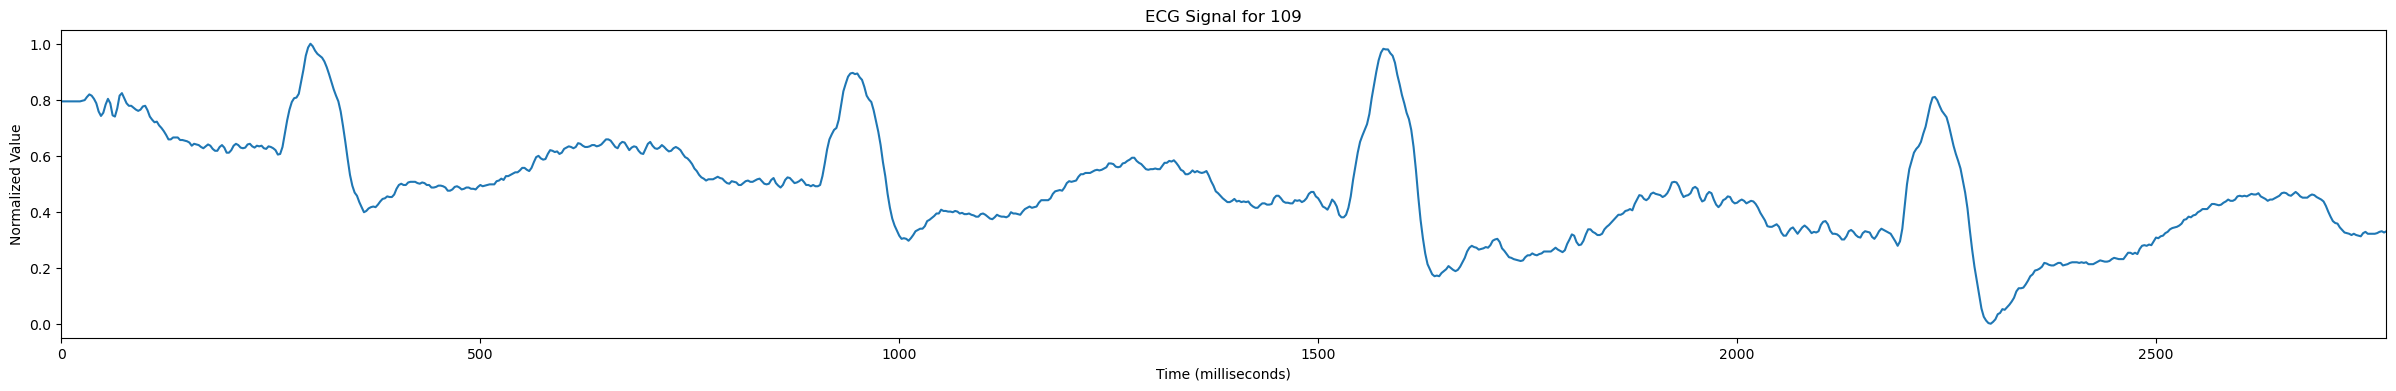


Record ID: 111
Annotations: 2133


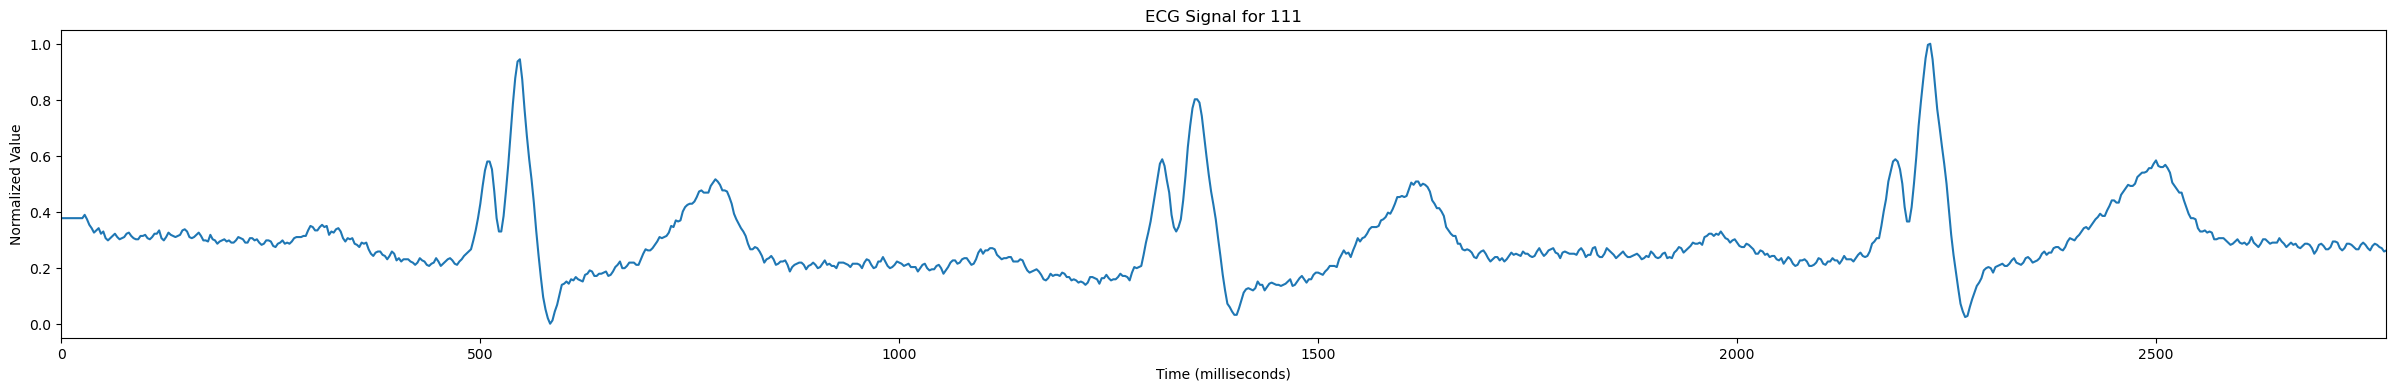


Record ID: 112
Annotations: 2550


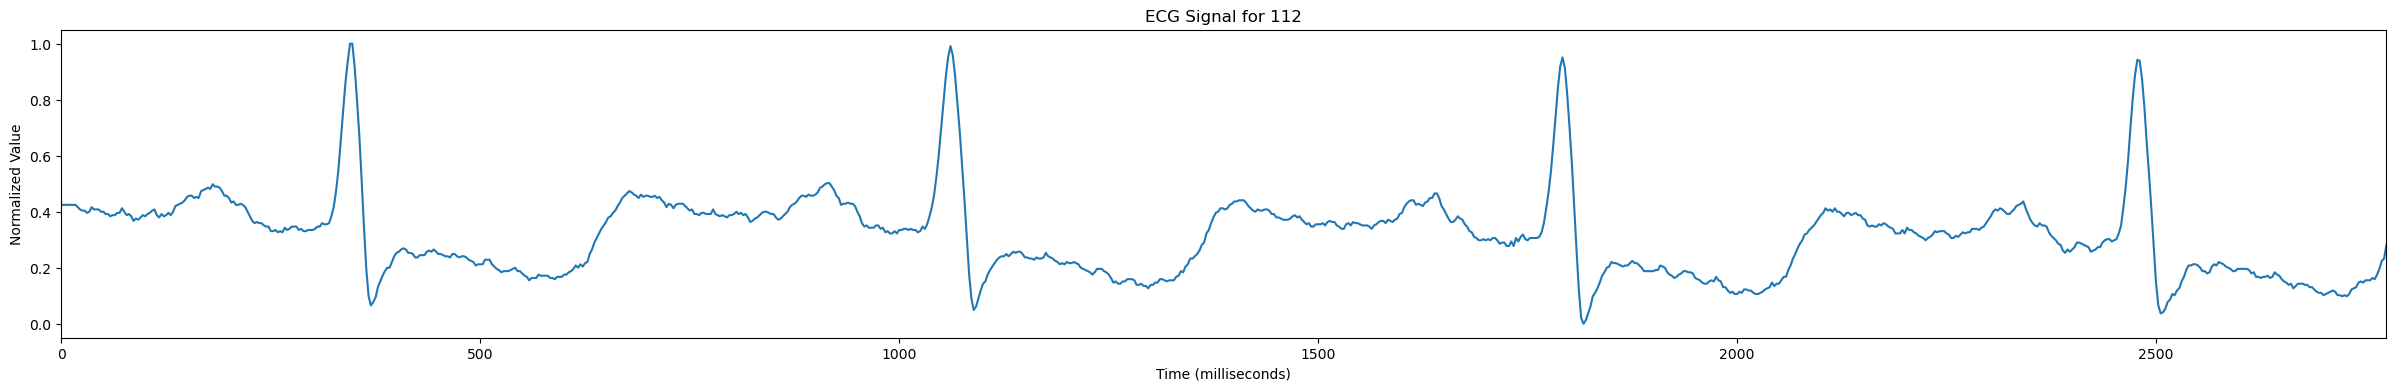


Record ID: 113
Annotations: 1796


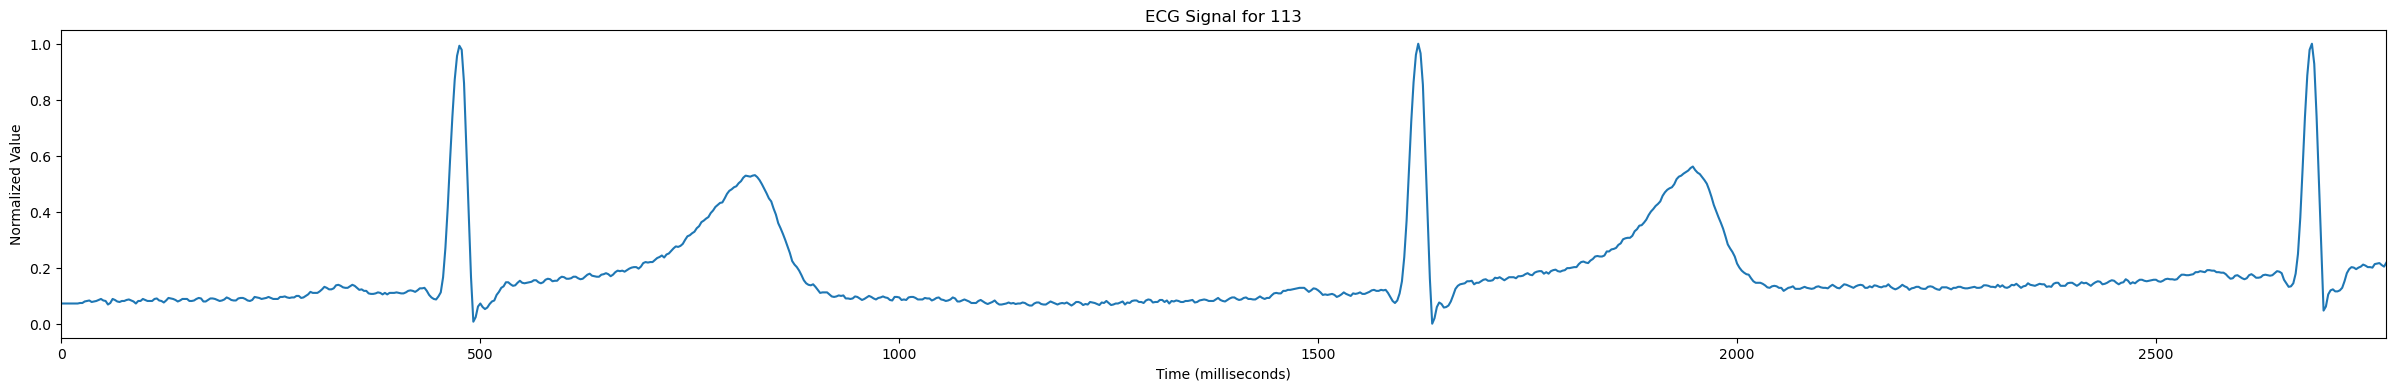


Record ID: 114
Annotations: 1890


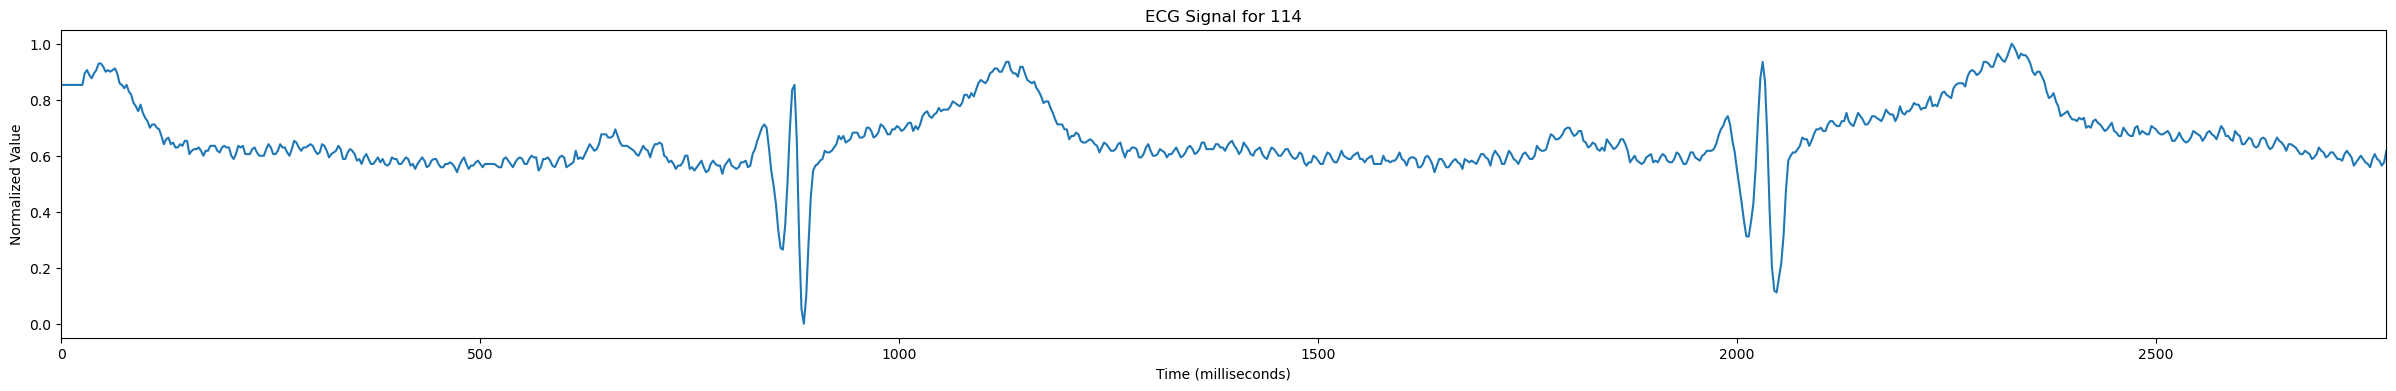


Record ID: 115
Annotations: 1962


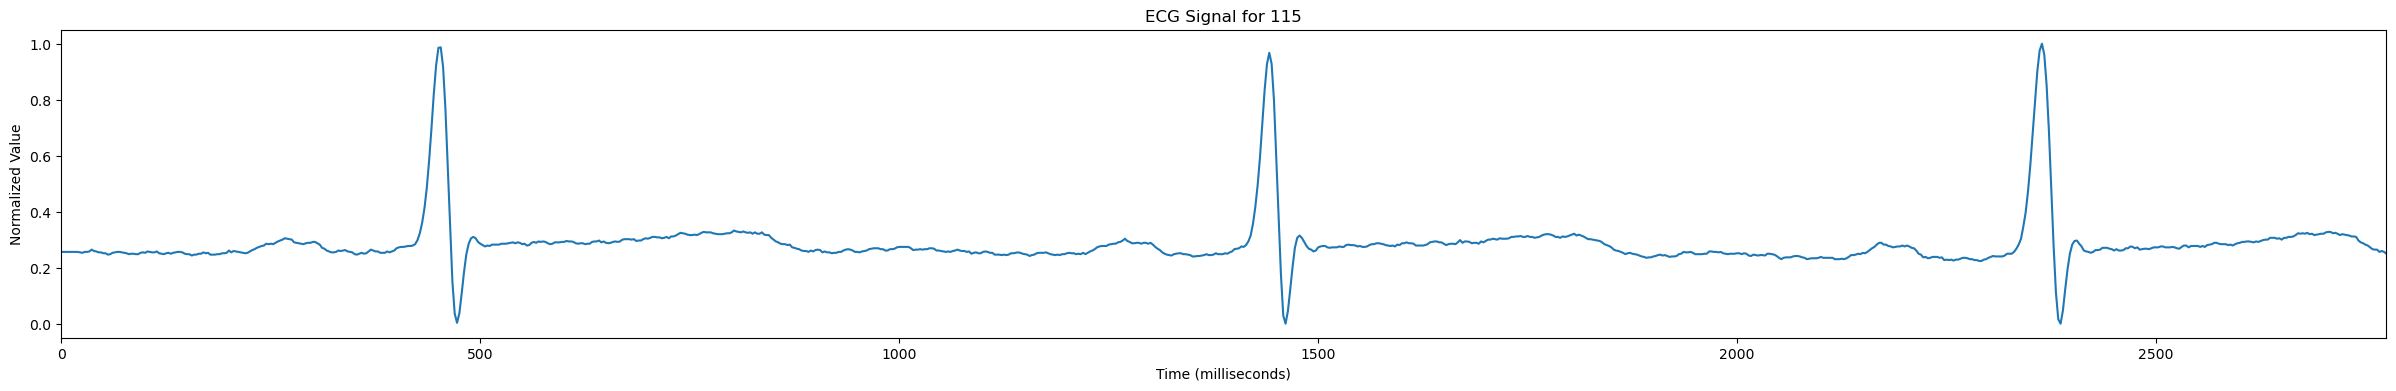


Record ID: 116
Annotations: 2421


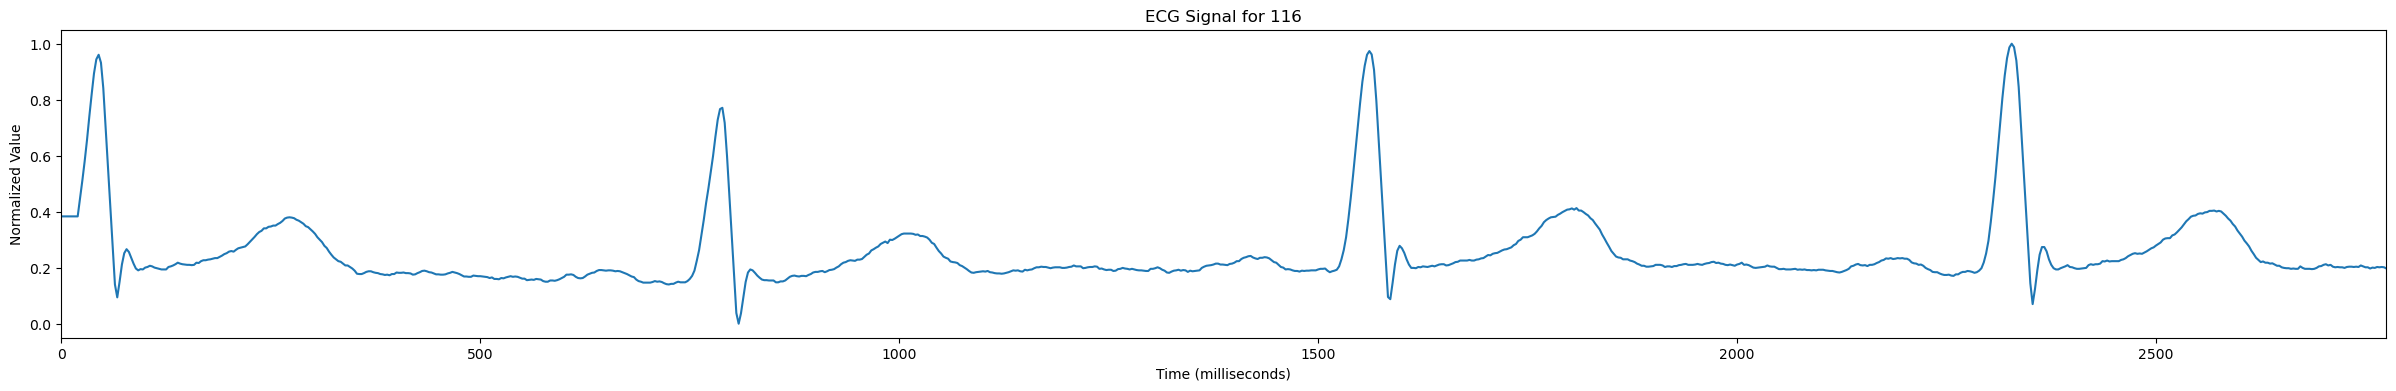


Record ID: 117
Annotations: 1539


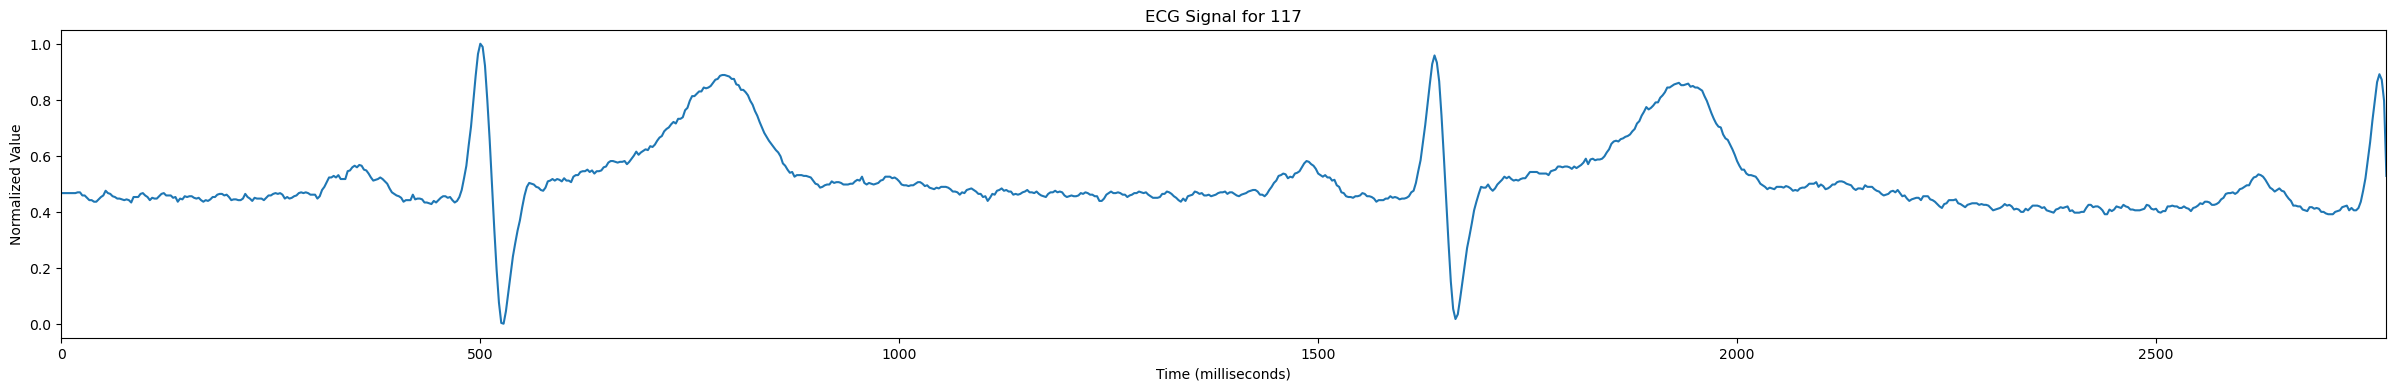


Record ID: 118
Annotations: 2301


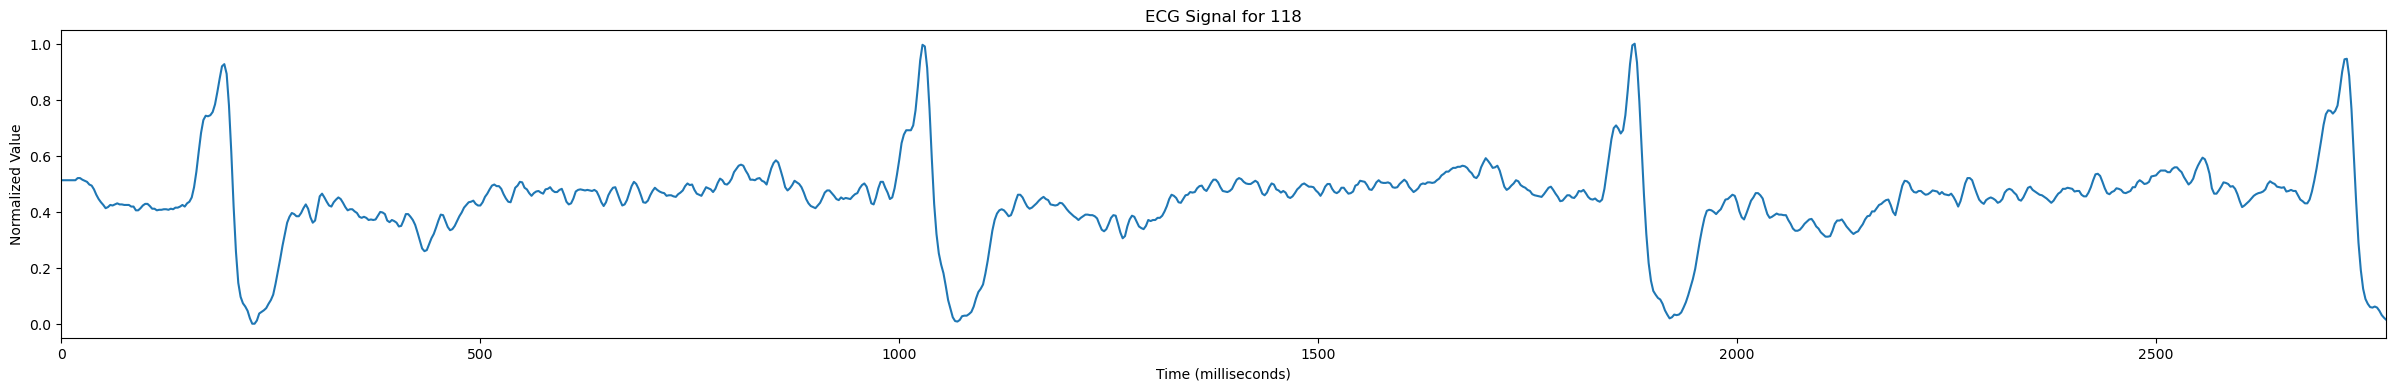


Record ID: 119
Annotations: 2094


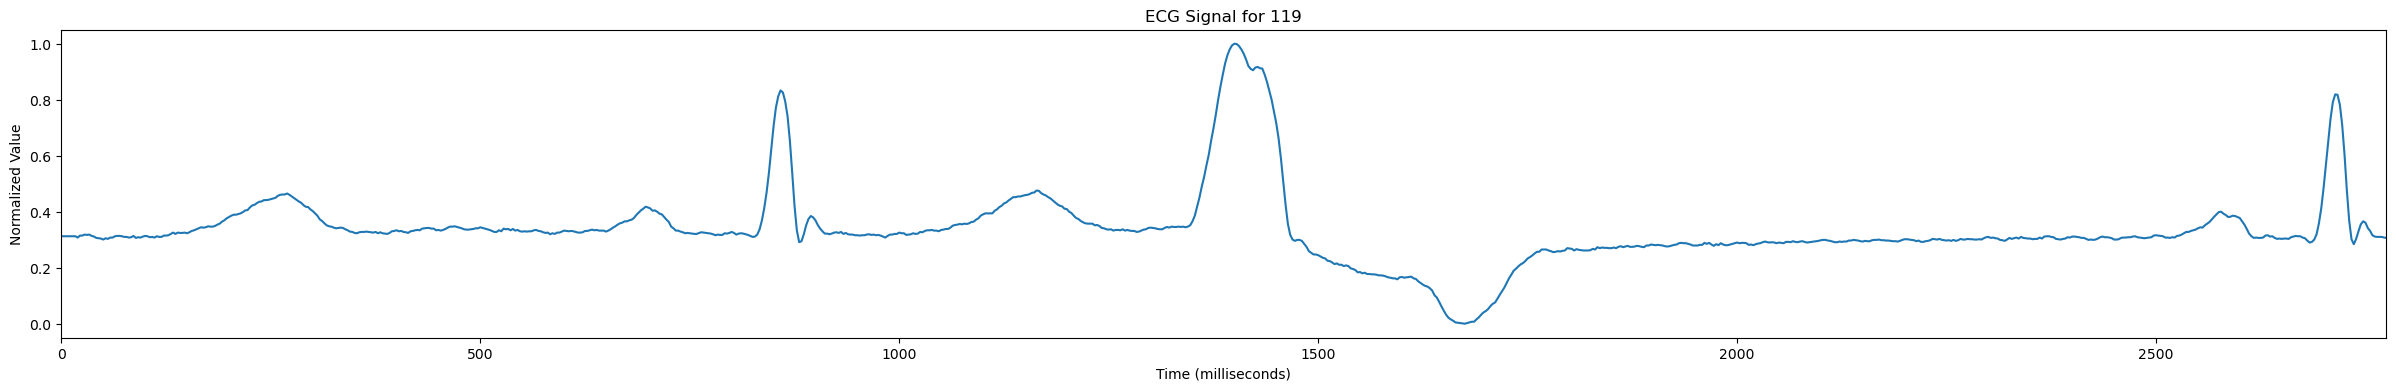


Record ID: 121
Annotations: 1876


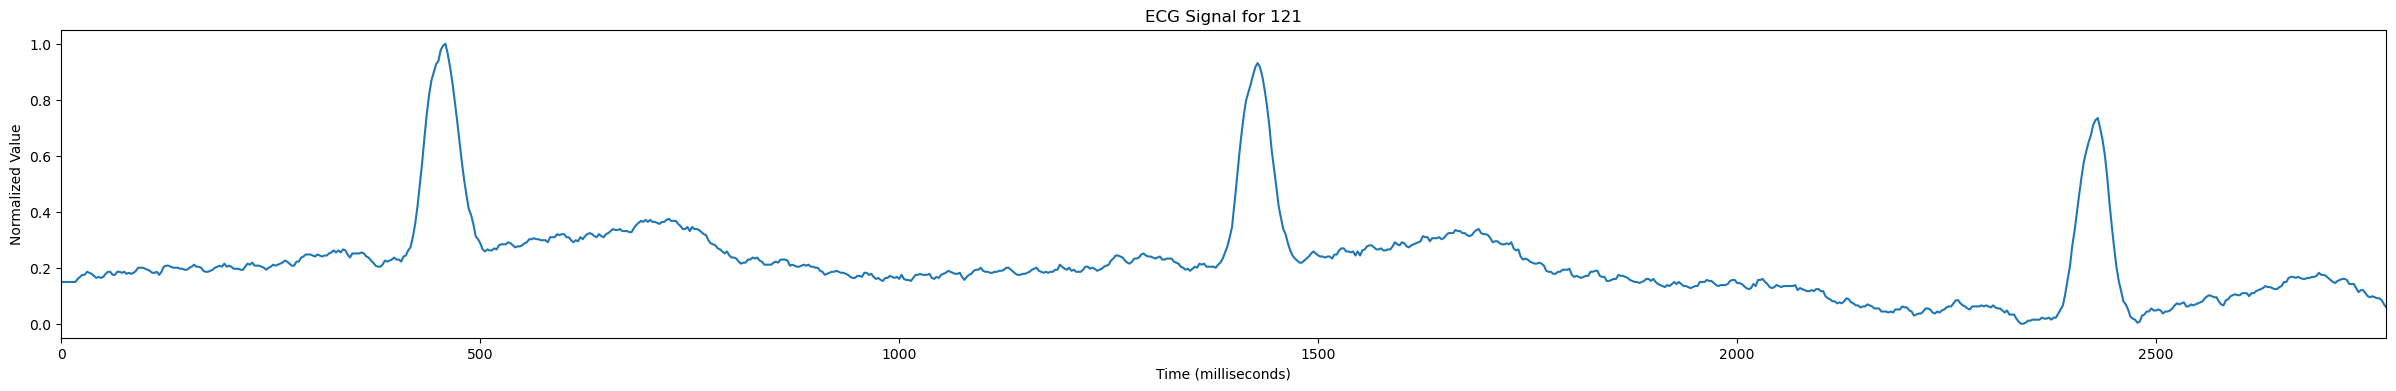


Record ID: 122
Annotations: 2479


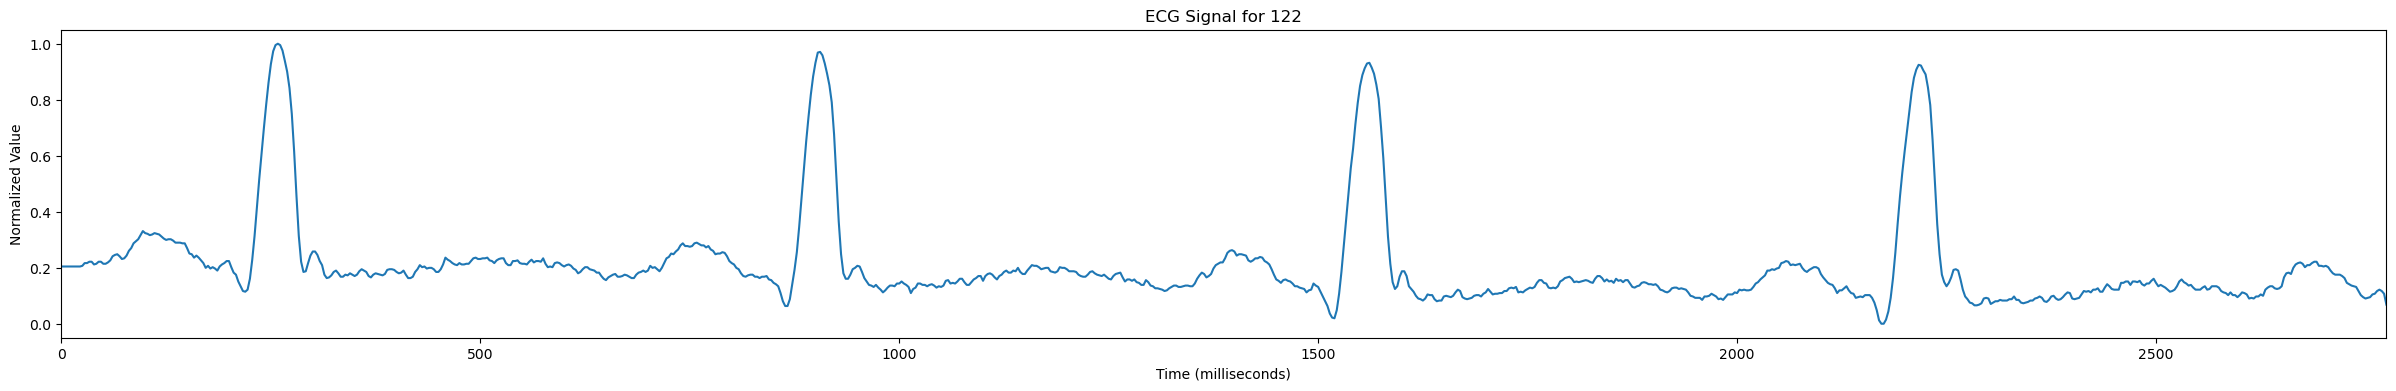


Record ID: 123
Annotations: 1519


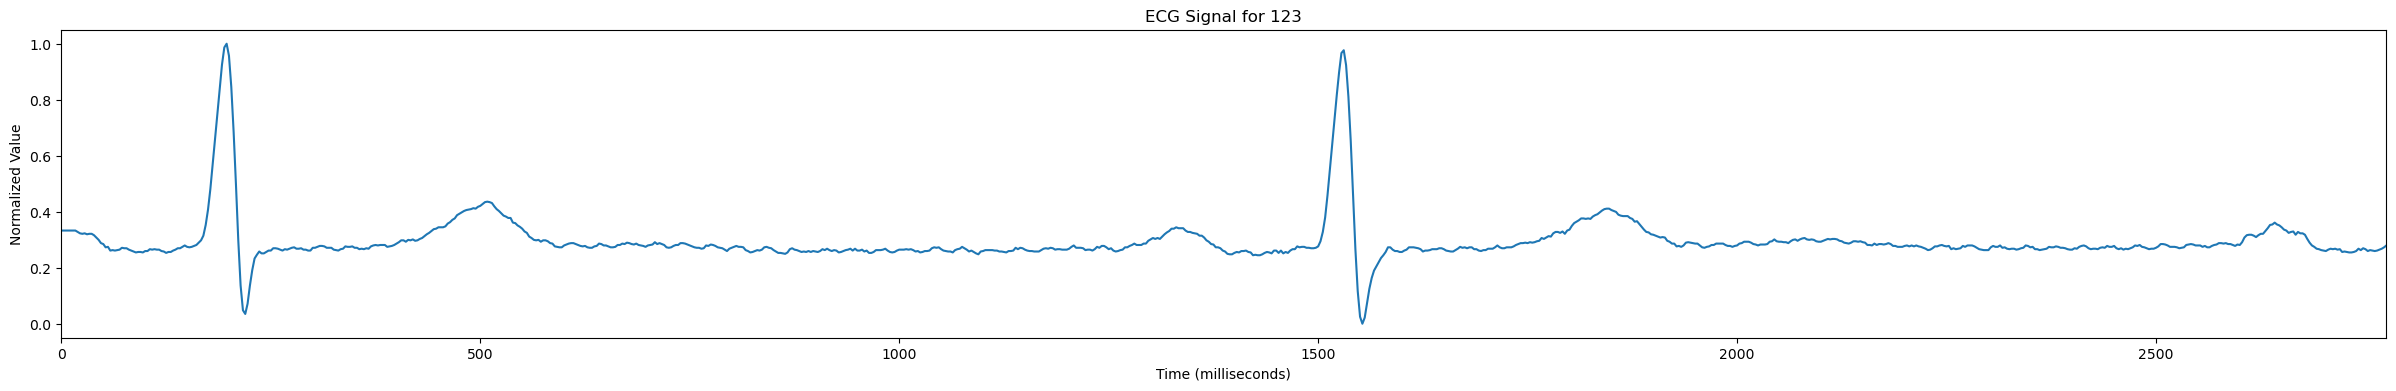


Record ID: 124
Annotations: 1634


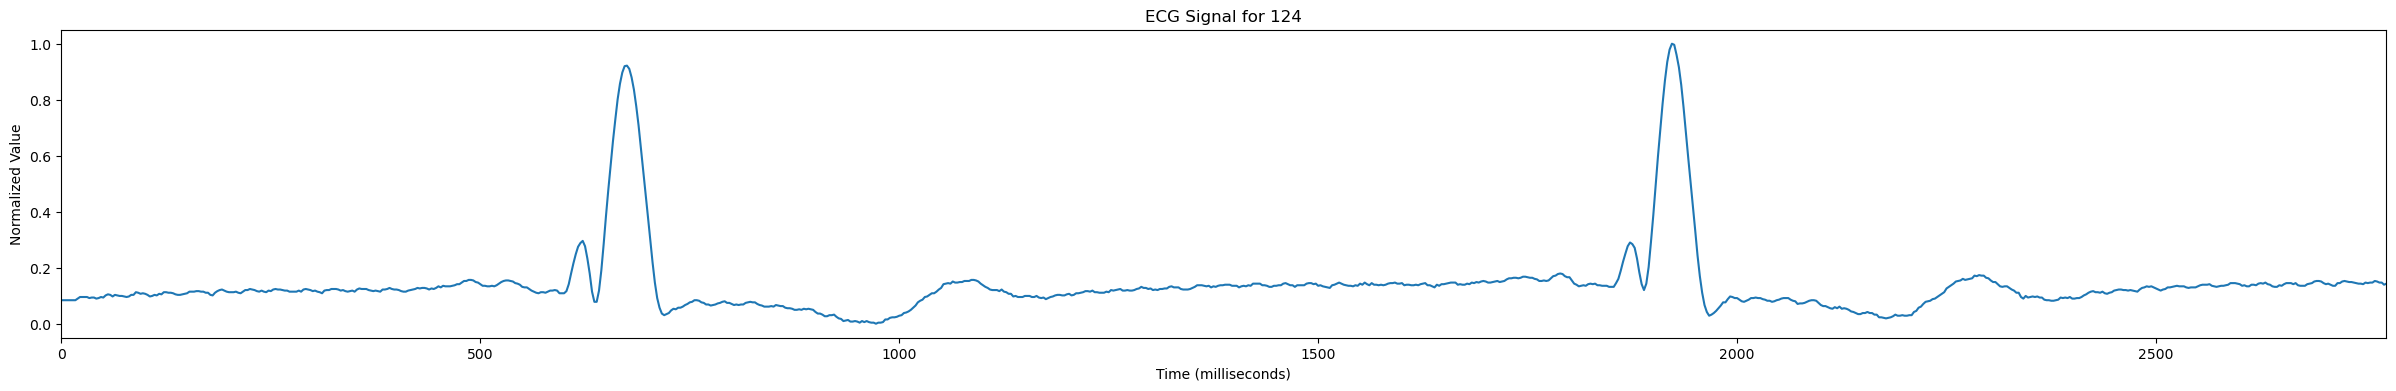


Record ID: 200
Annotations: 2792


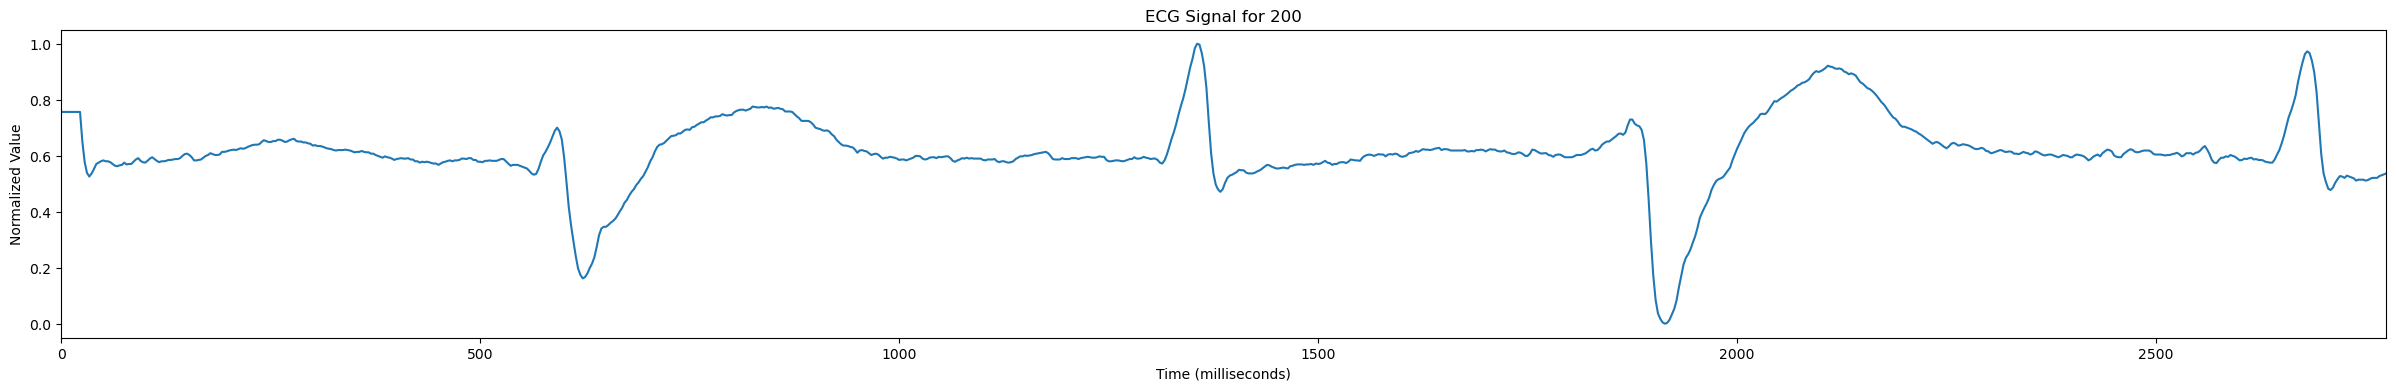


Record ID: 201
Annotations: 2039


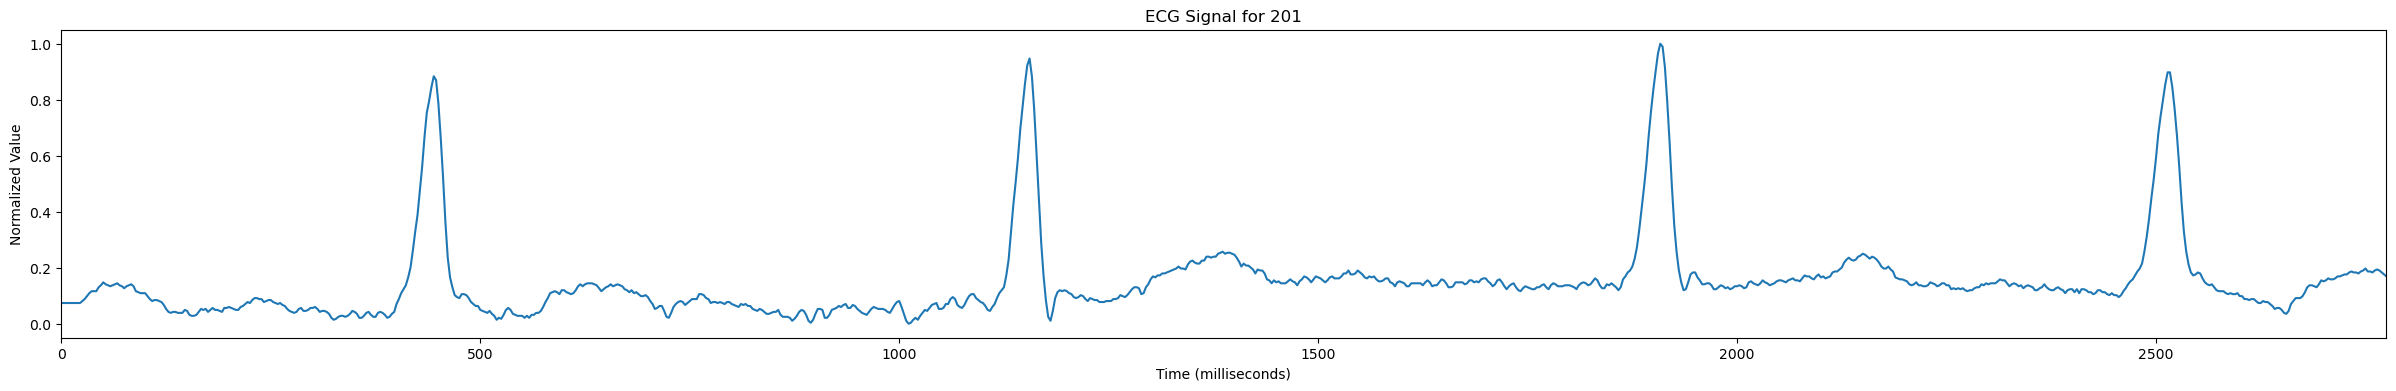


Record ID: 202
Annotations: 2146


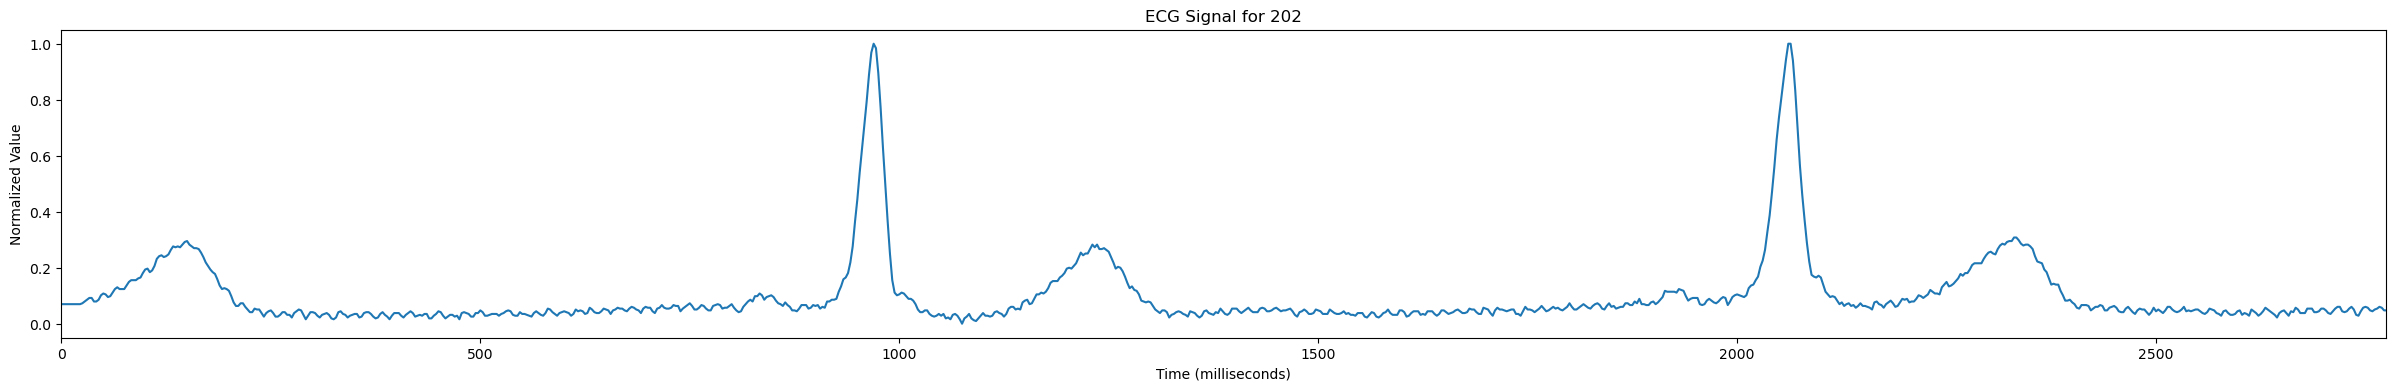


Record ID: 203
Annotations: 3108


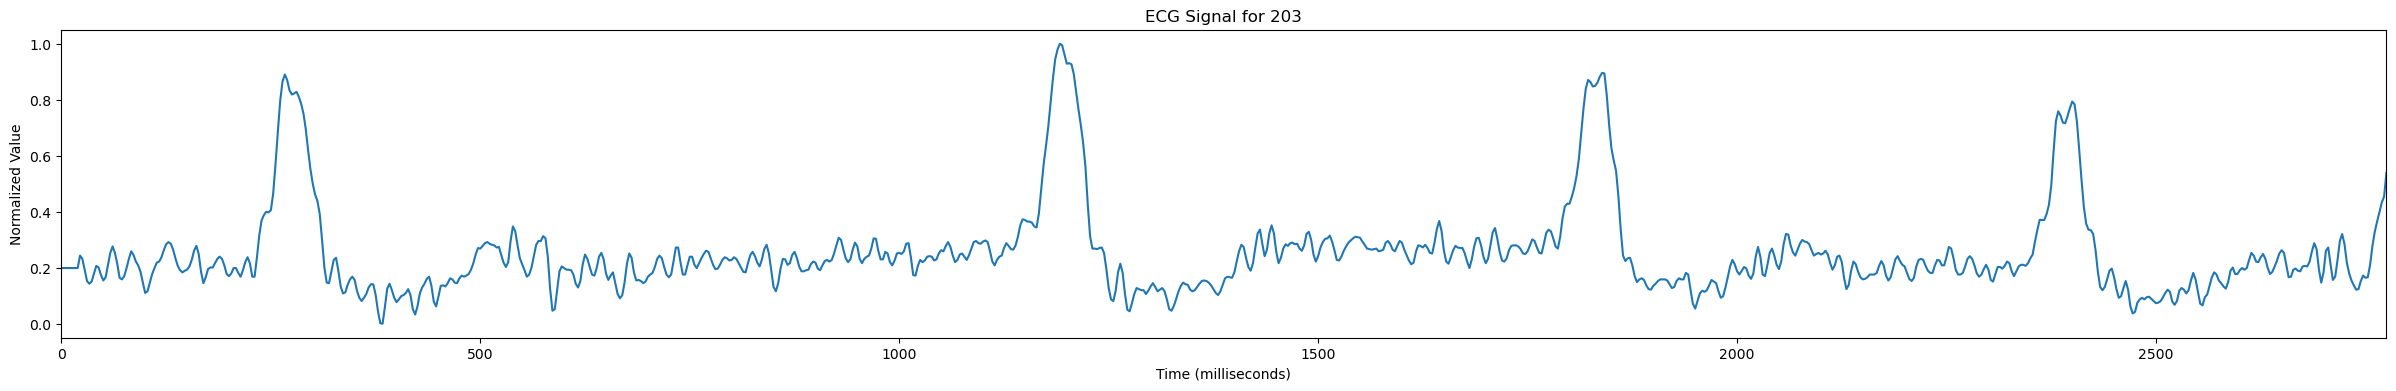


Record ID: 205
Annotations: 2672


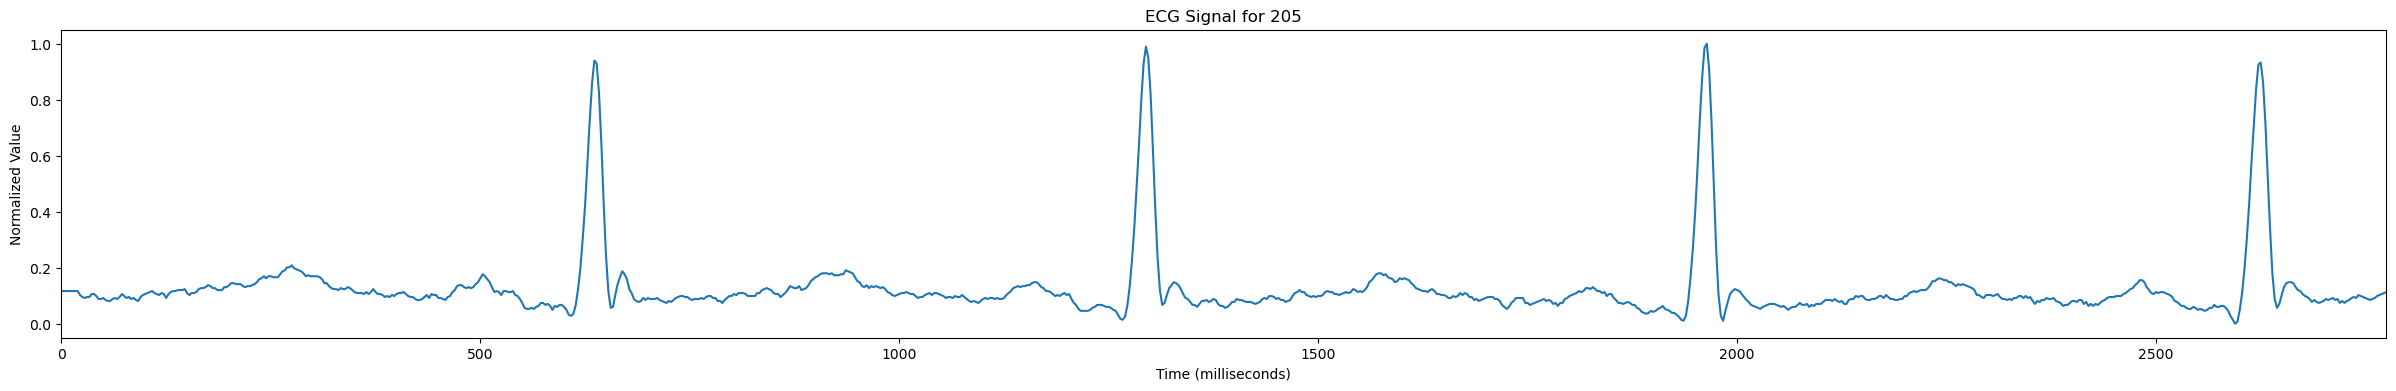


Record ID: 207
Annotations: 2385


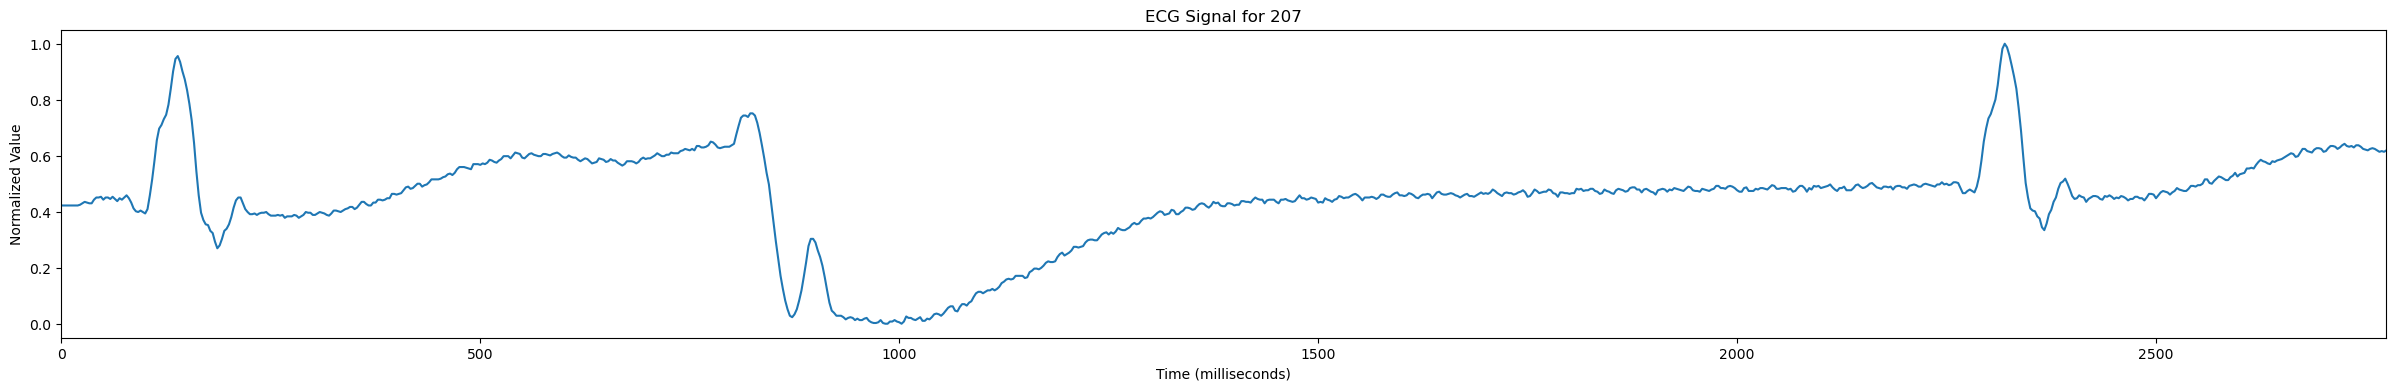


Record ID: 208
Annotations: 3040


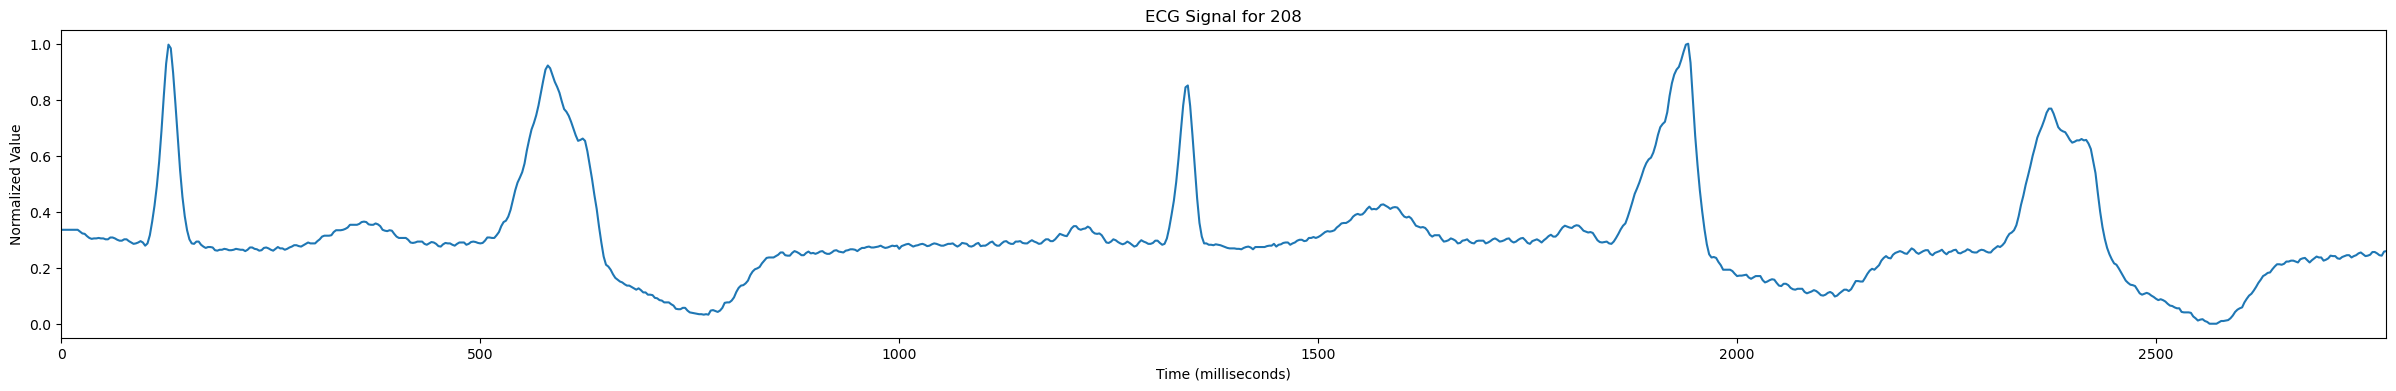


Record ID: 209
Annotations: 3052


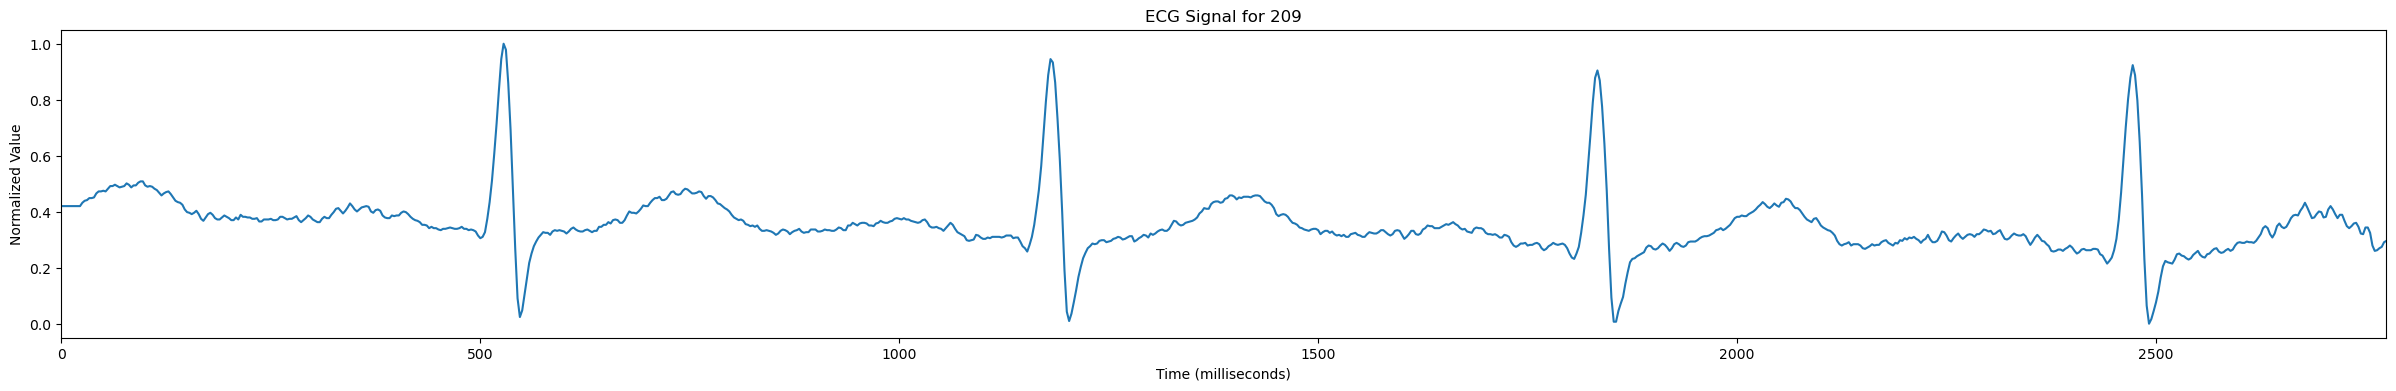


Record ID: 210
Annotations: 2685


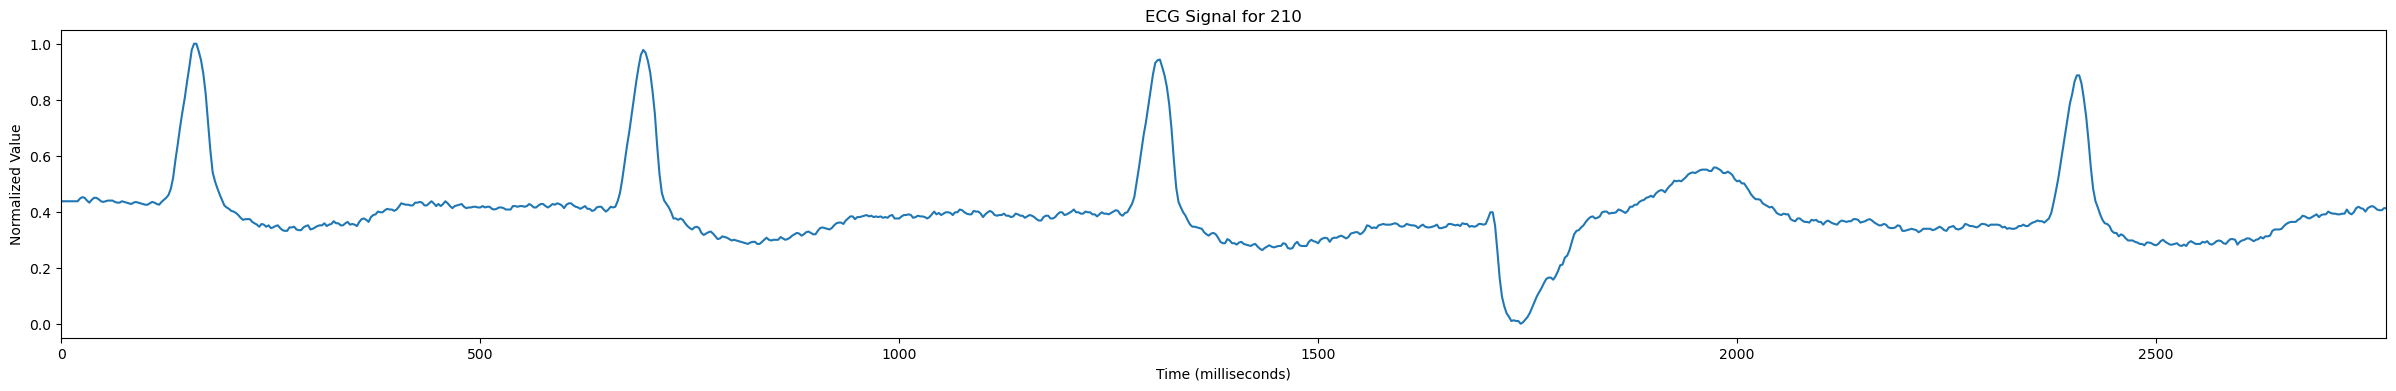


Record ID: 212
Annotations: 2763


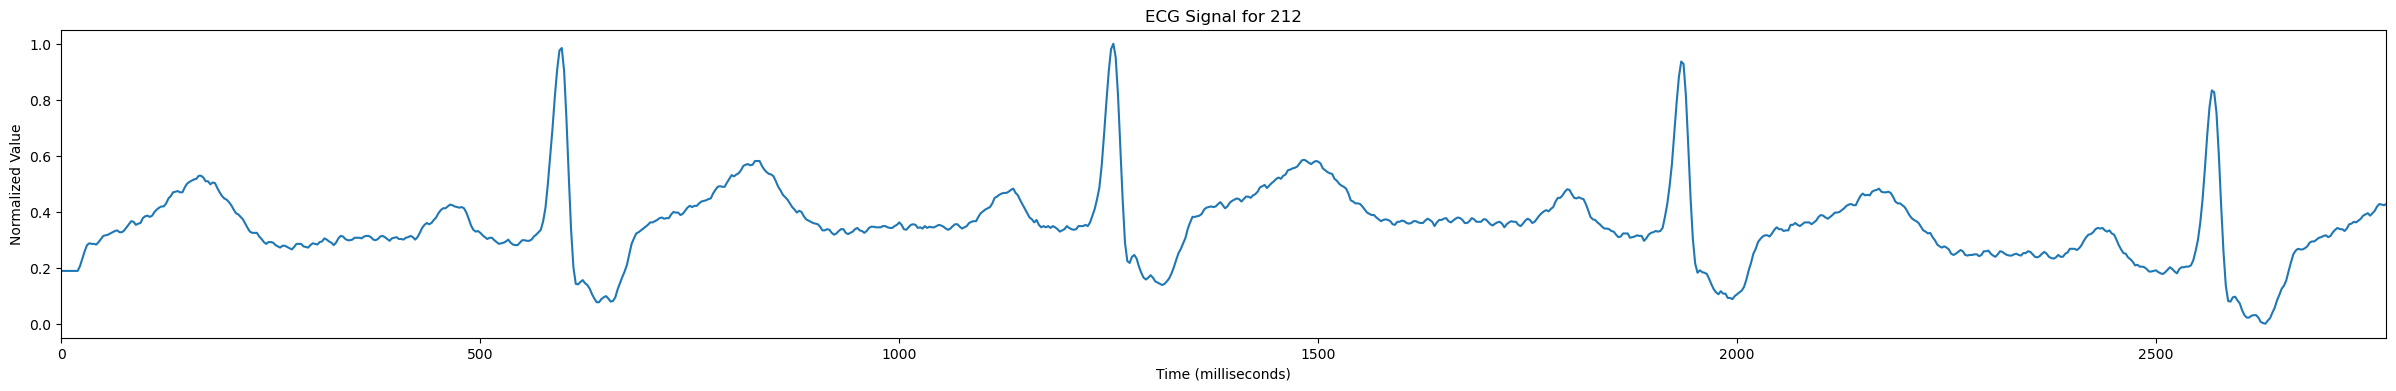


Record ID: 213
Annotations: 3294


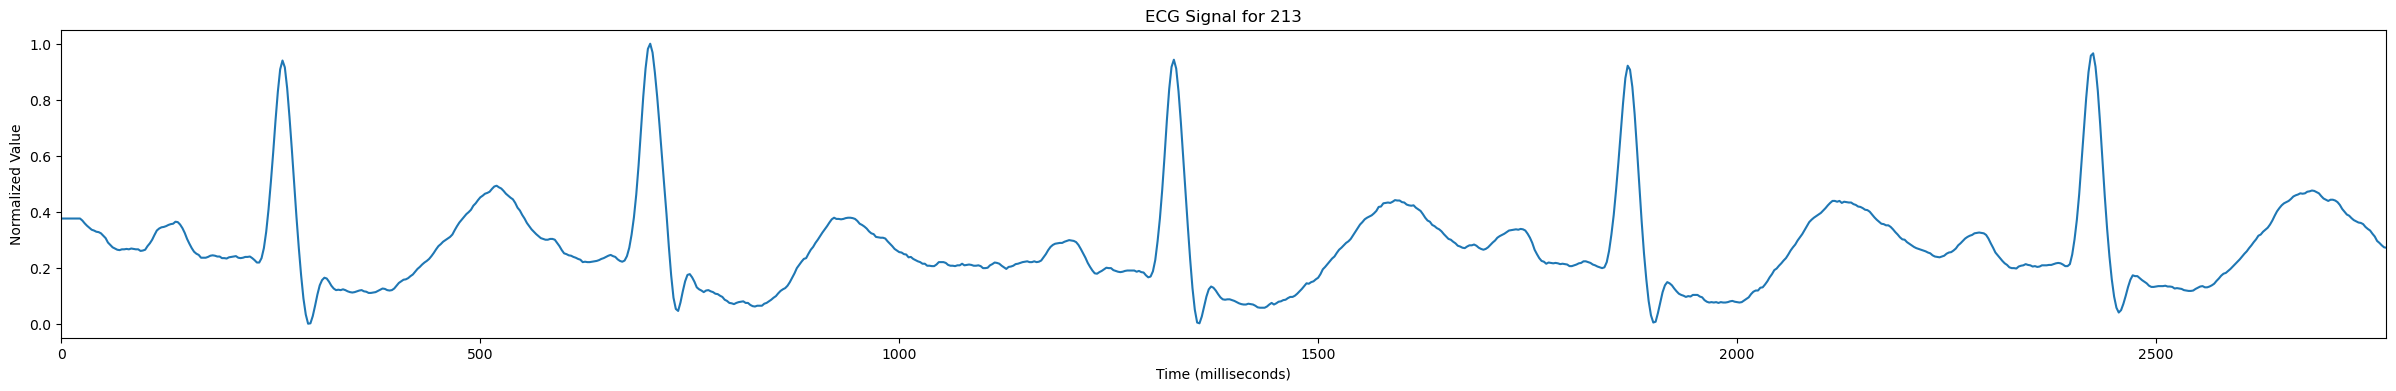


Record ID: 214
Annotations: 2297


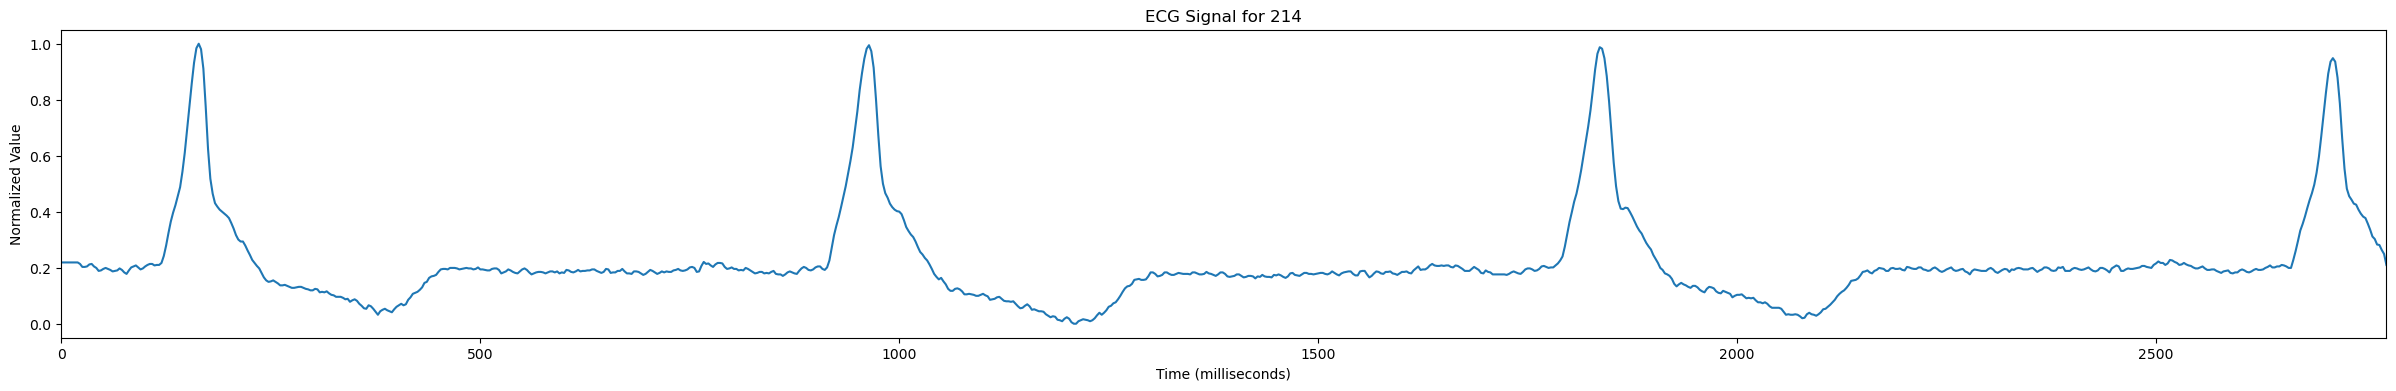


Record ID: 215
Annotations: 3400


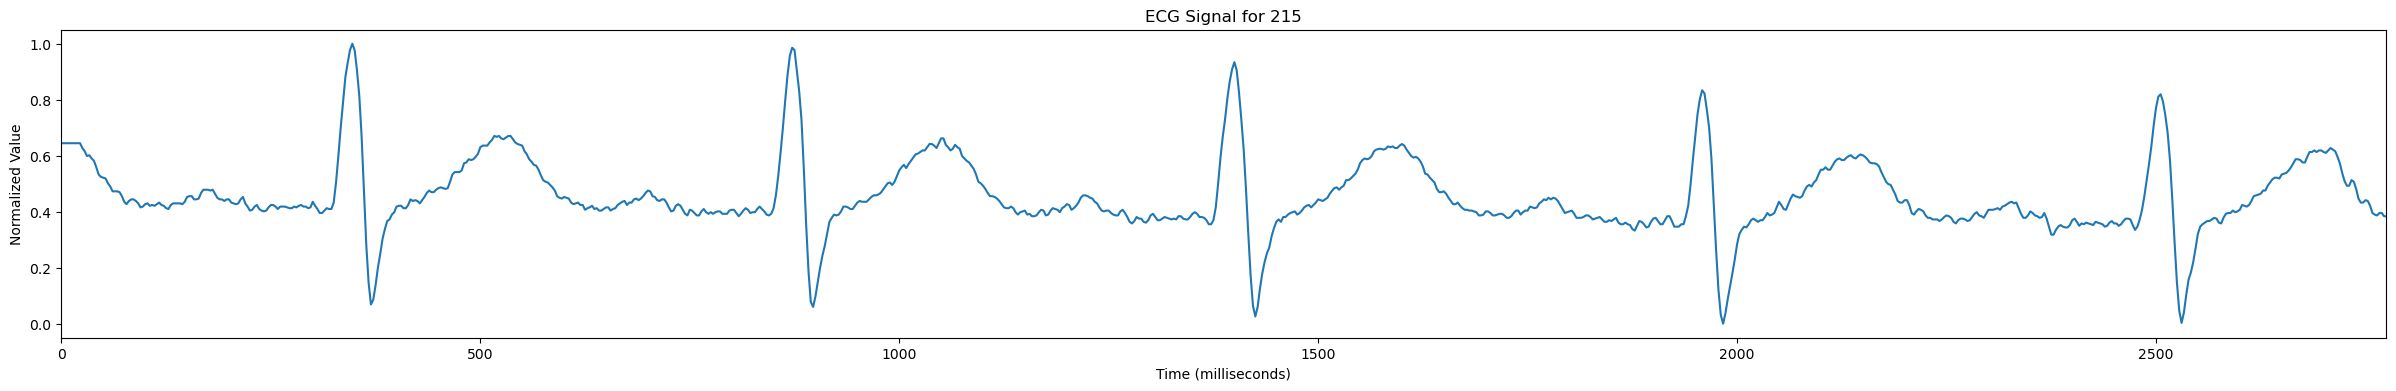


Record ID: 217
Annotations: 2280


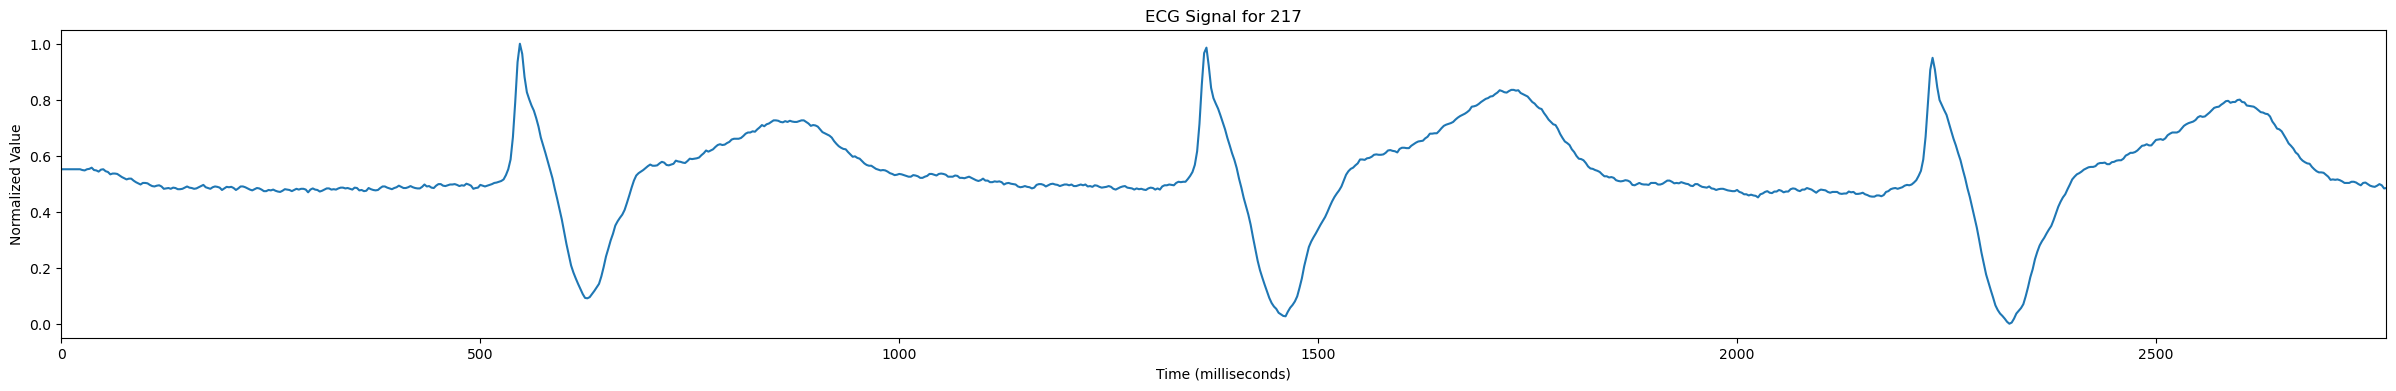


Record ID: 219
Annotations: 2312


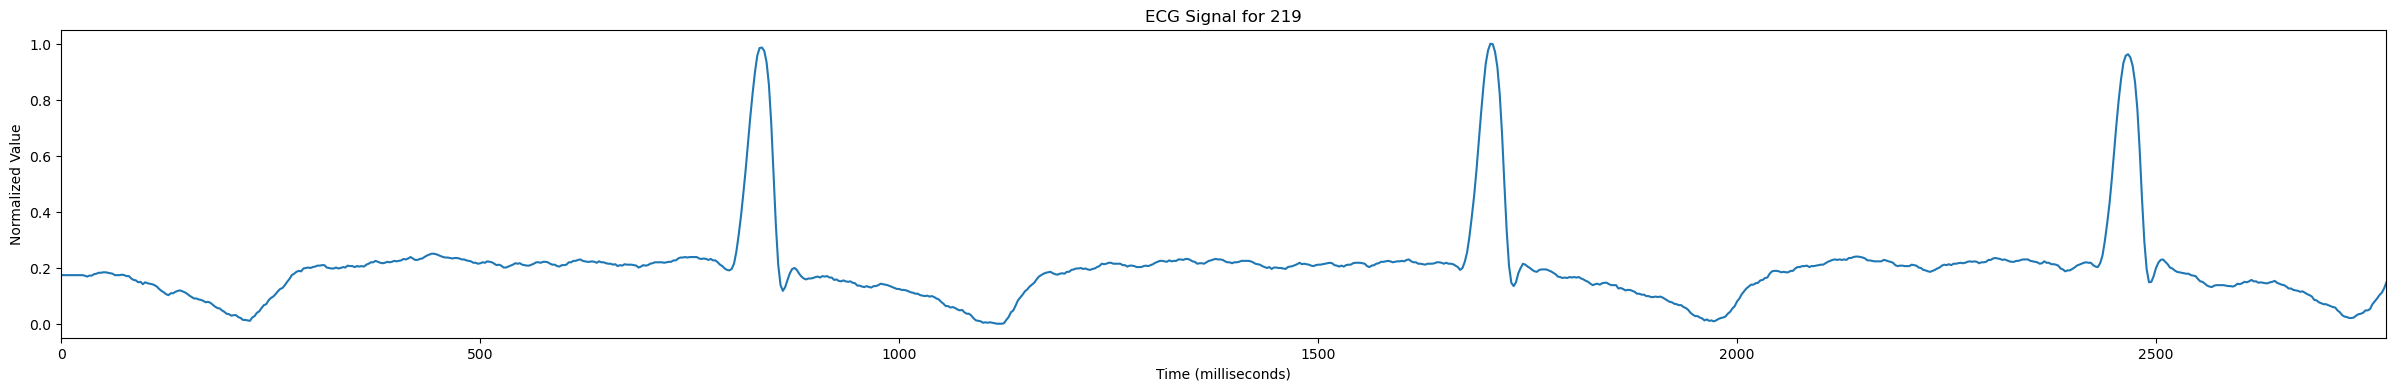


Record ID: 220
Annotations: 2069


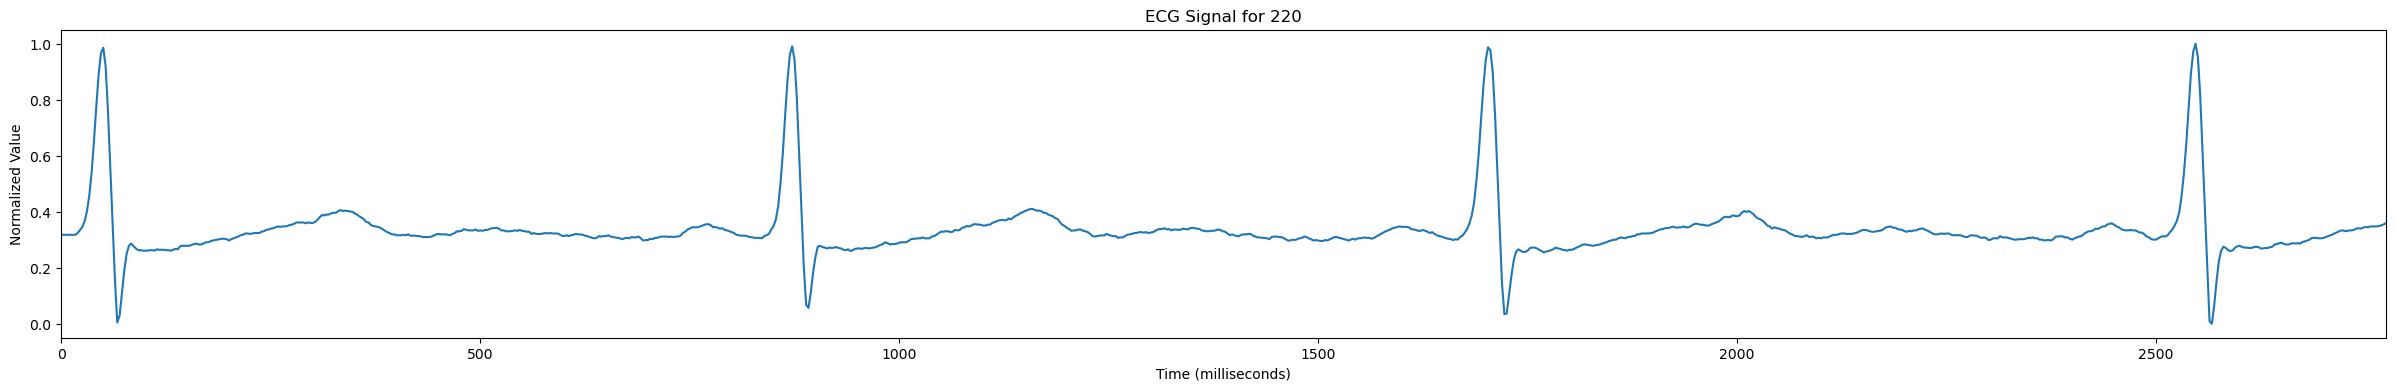


Record ID: 221
Annotations: 2462


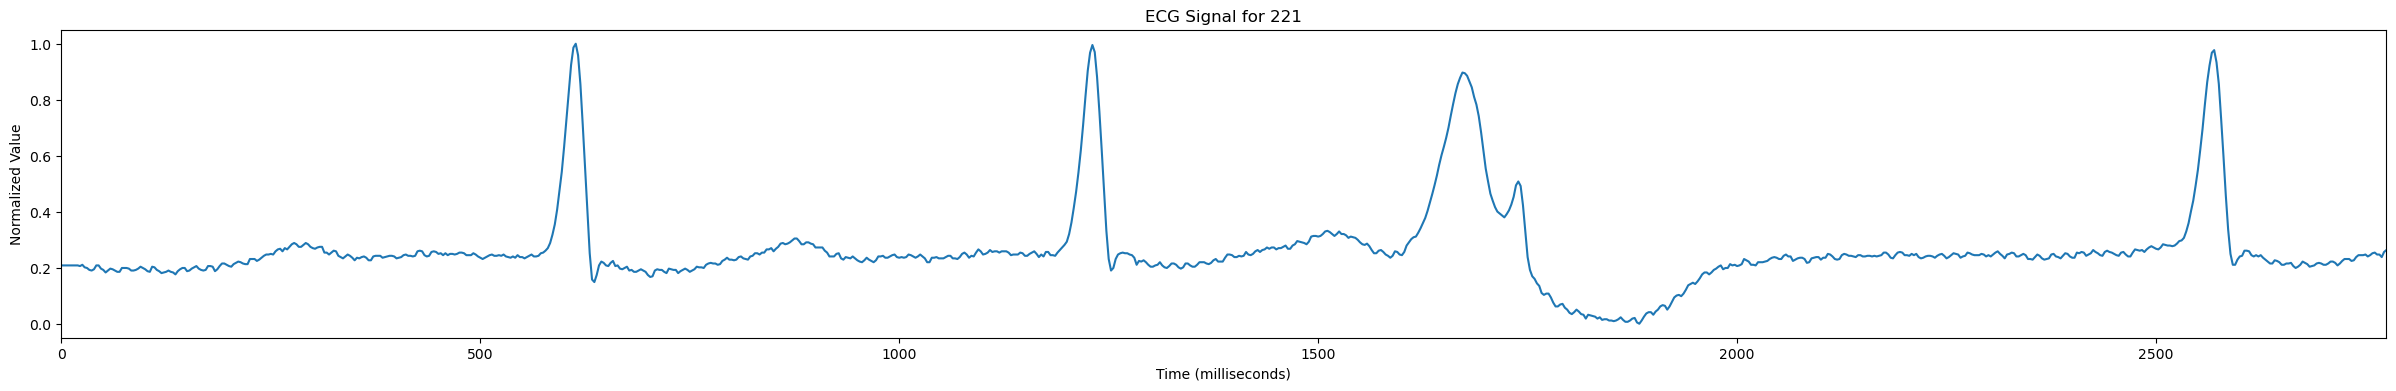


Record ID: 222
Annotations: 2634


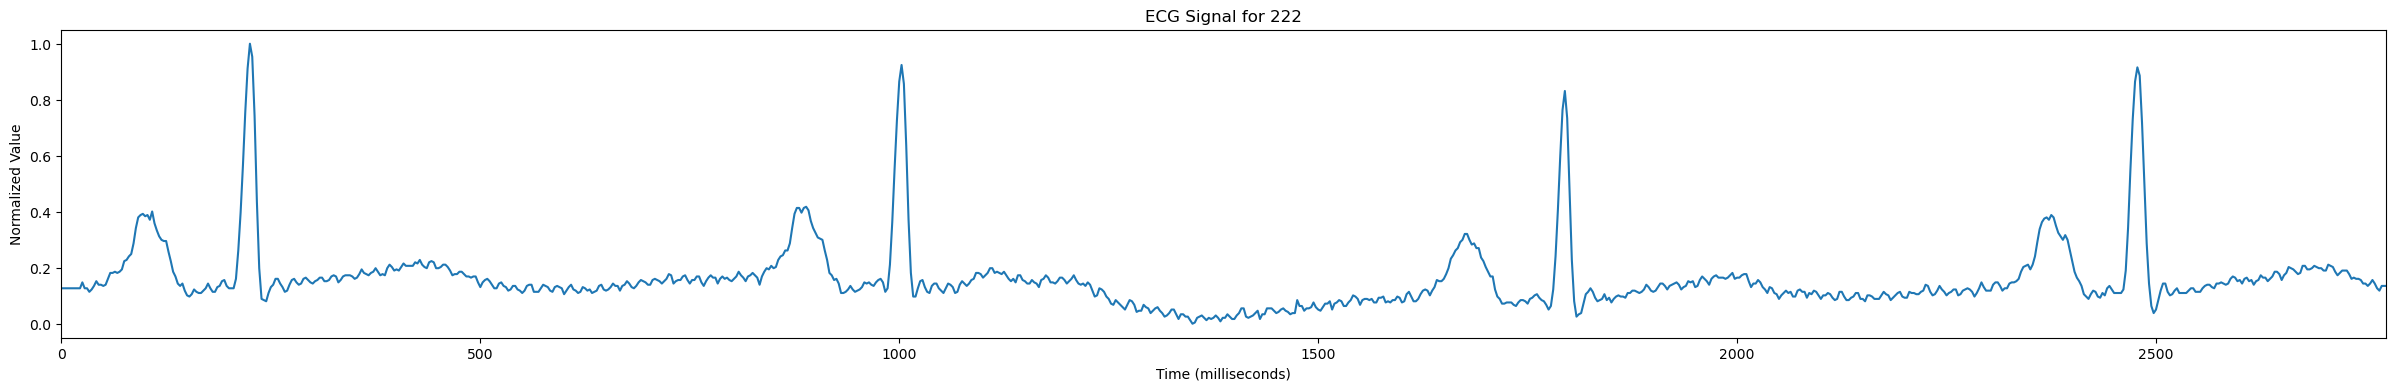


Record ID: 223
Annotations: 2643


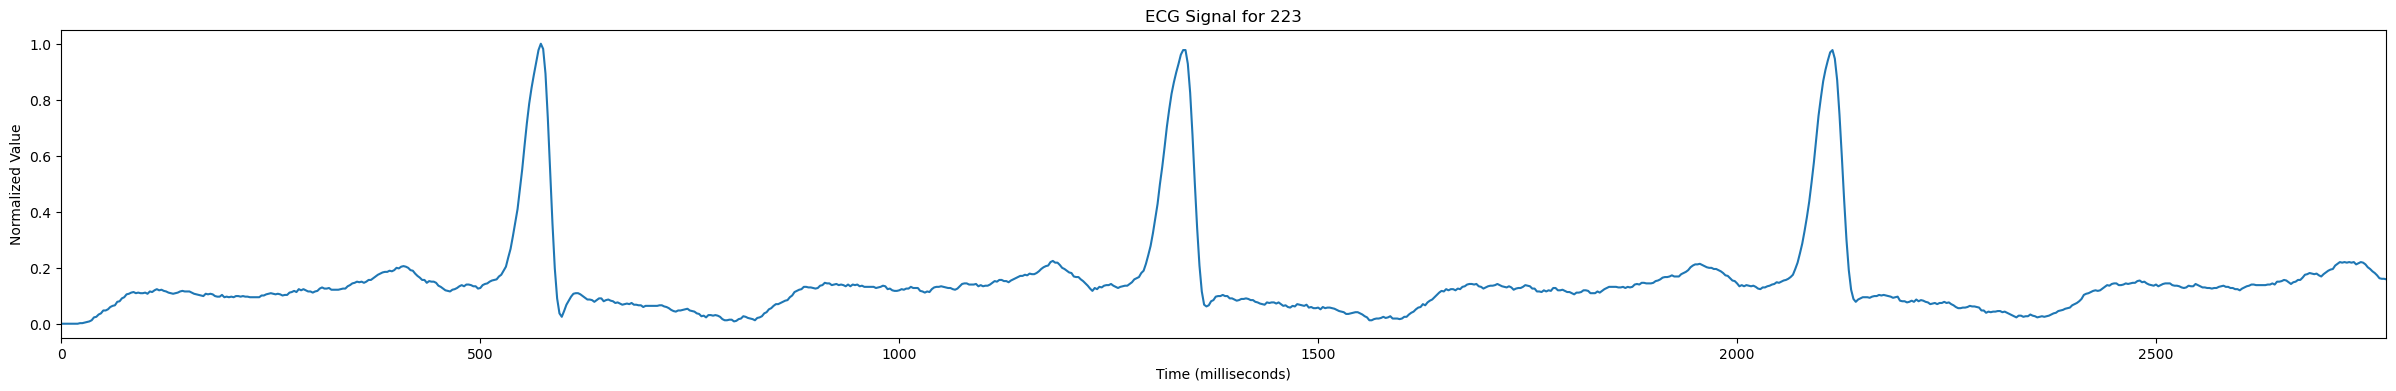


Record ID: 228
Annotations: 2141


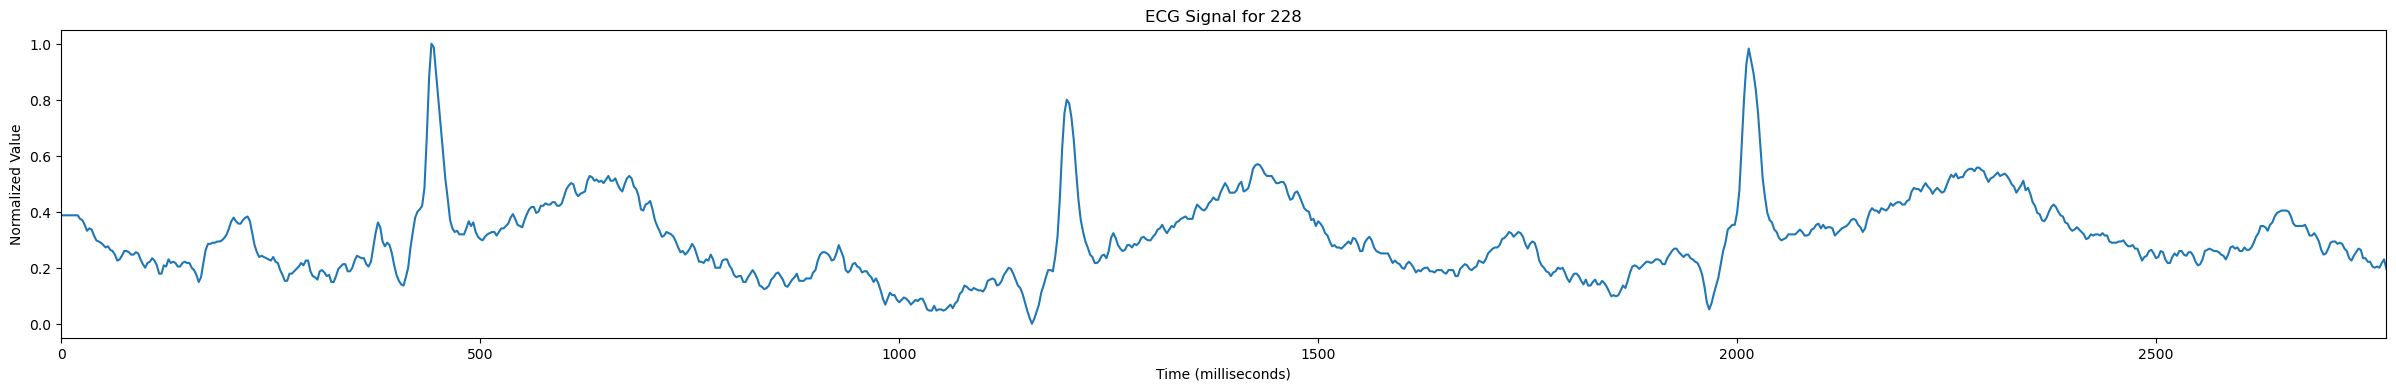


Record ID: 230
Annotations: 2466


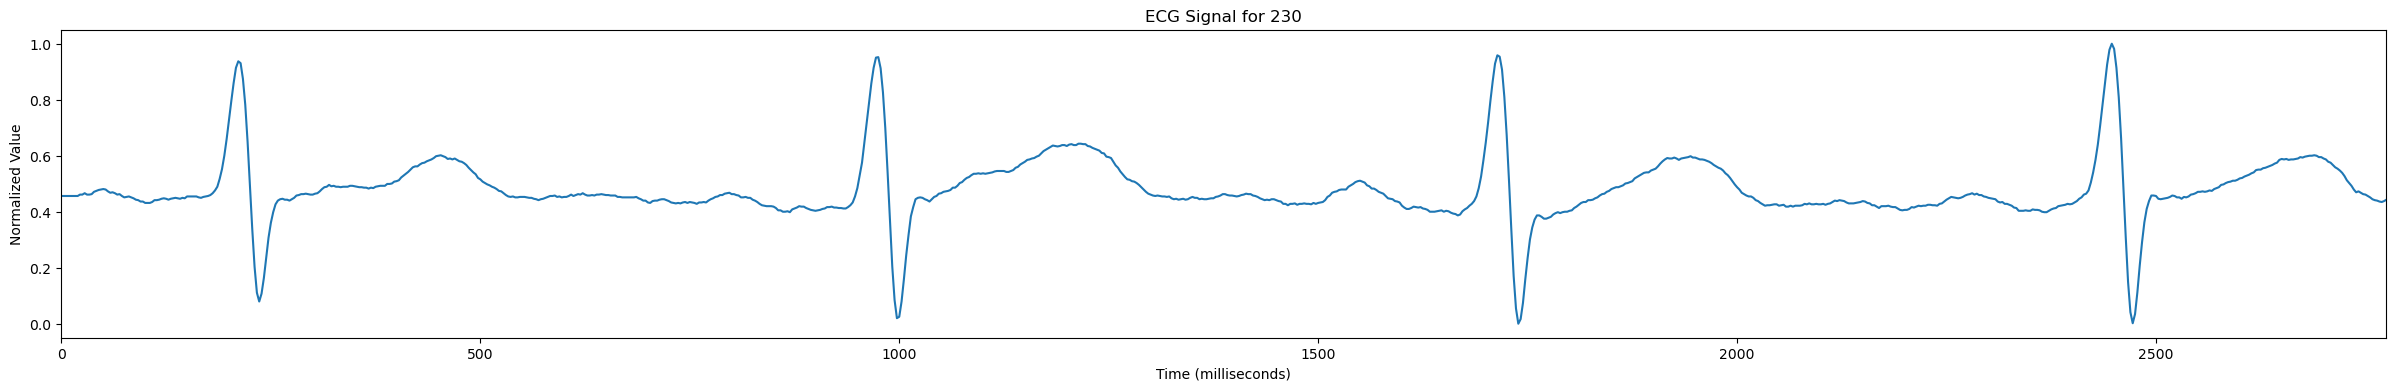


Record ID: 231
Annotations: 2011


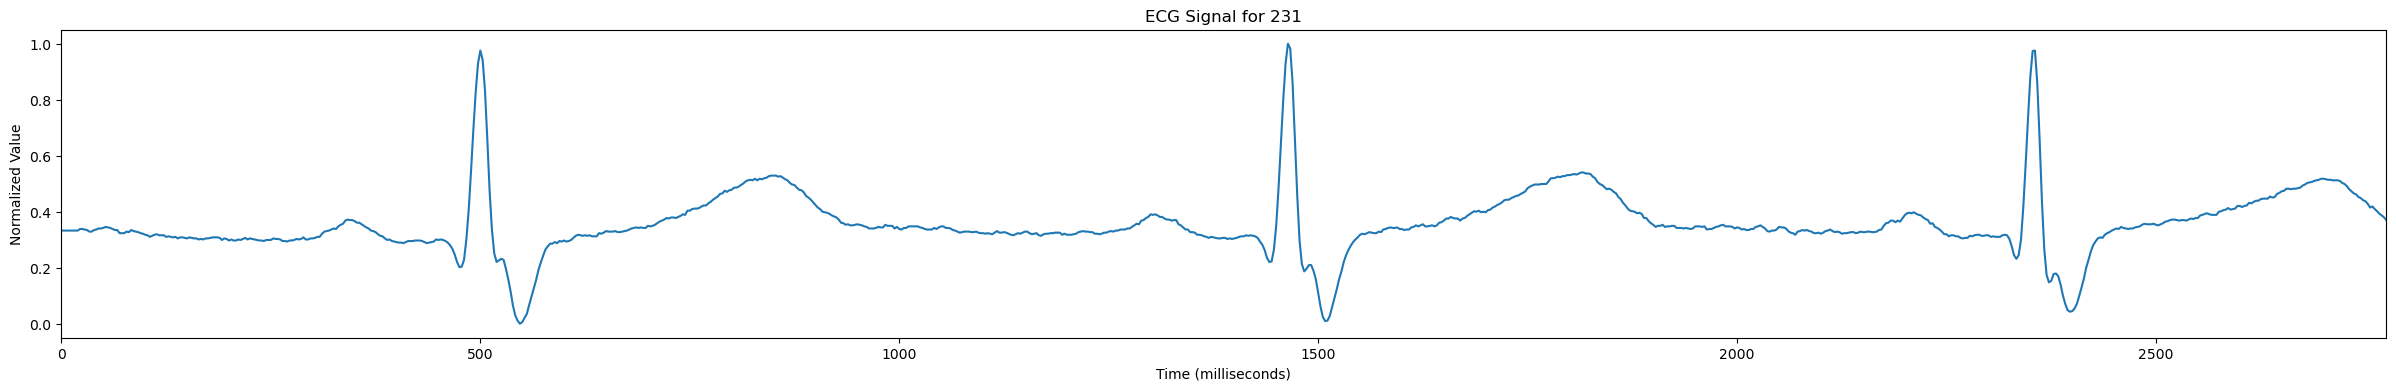


Record ID: 232
Annotations: 1816


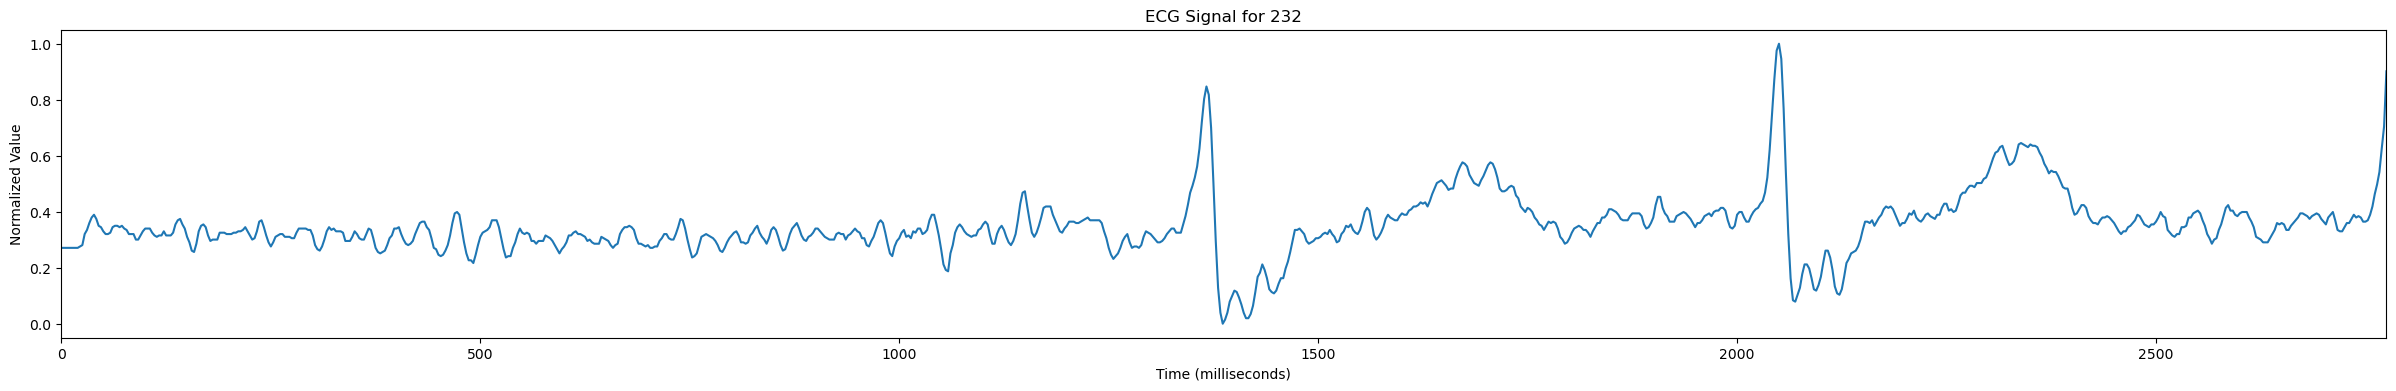


Record ID: 233
Annotations: 3152


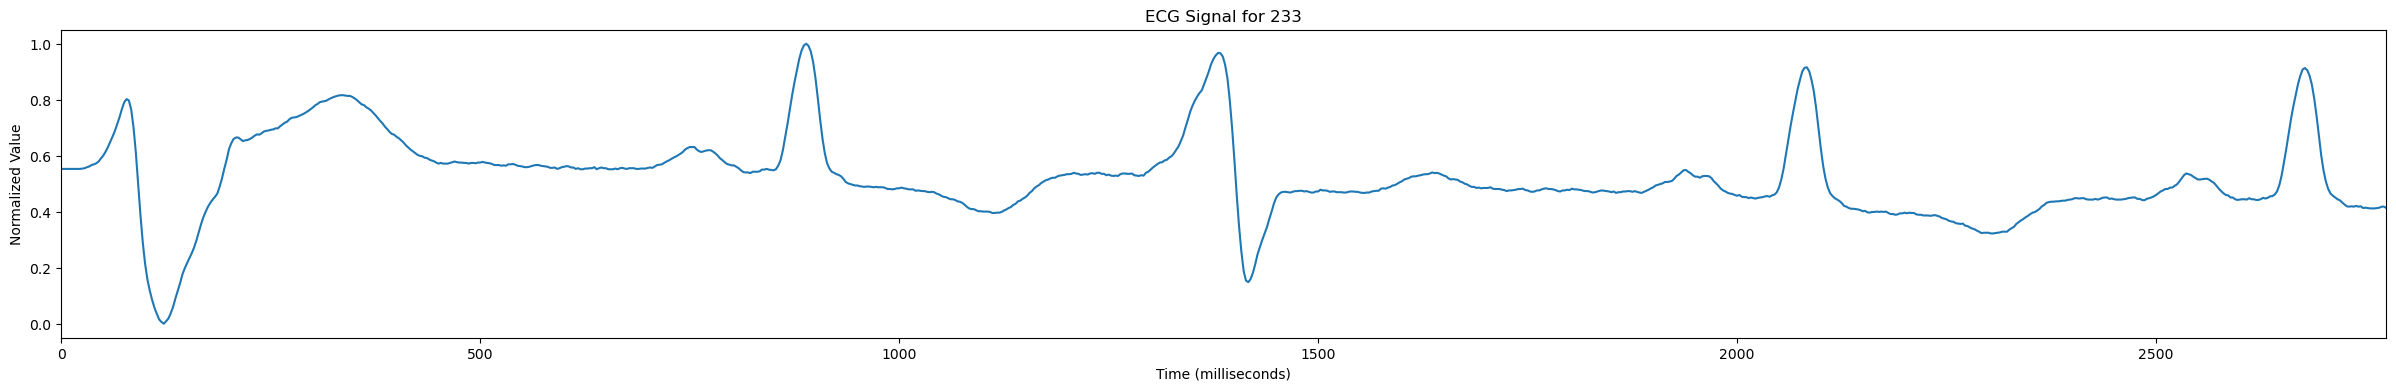


Record ID: 234
Annotations: 2764


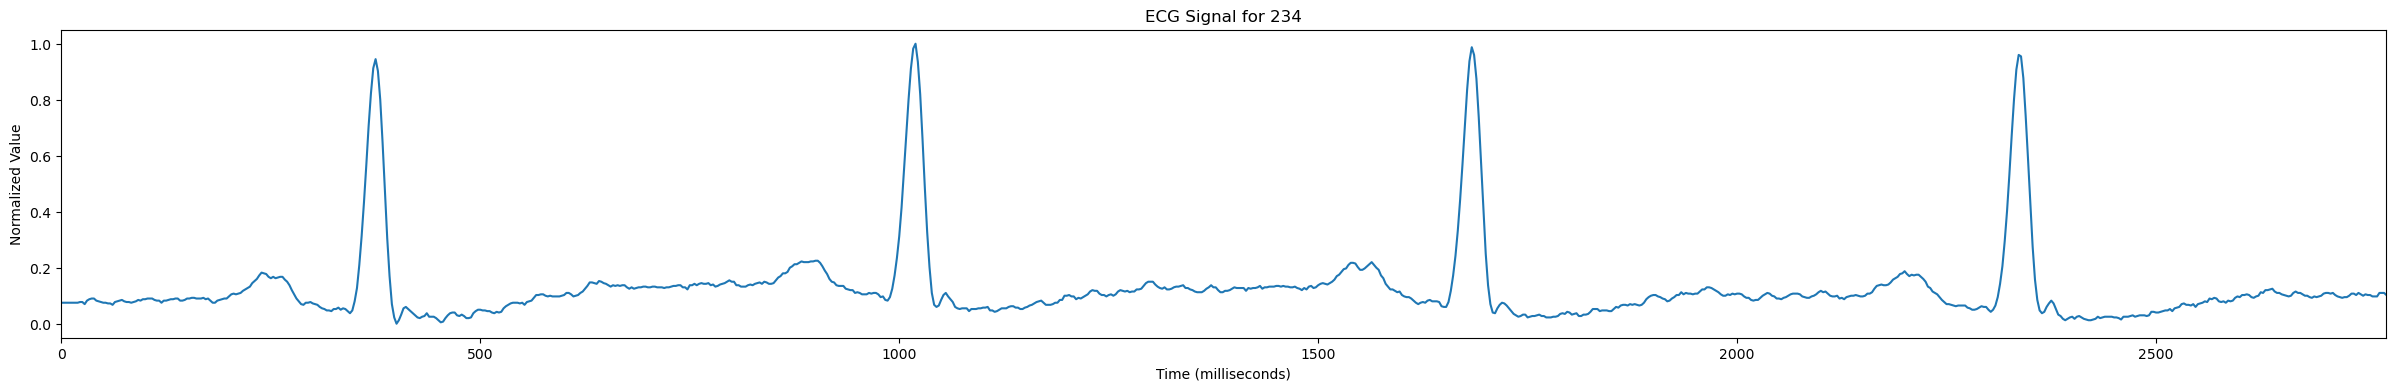

In [10]:
for record_id in data_records:
    record_path = os.path.join(arrhythmia_data, record_id)
    record_data, record_info = wf.rdsamp(record_path)
    annotation_data = wf.rdann(record_path, 'atr')
    print(f'\nRecord ID: {record_id}')
    print('Annotations:', len(annotation_data.num))

    sample_start = 0 
    sample_size = 1000 
    channel = record_data[sample_start:sample_start + sample_size, 0]  

    # Normalize the values
    normalized_channel = (channel - channel.min()) / channel.ptp()

    # Plot the heartbeats
    times = (np.arange(sample_size, dtype='float') + sample_start) / record_info['fs'] * 1000
    plt.figure(figsize=(30, 4))
    plt.plot(times, normalized_channel)

    where = np.logical_and(annotation_data.sample >= sample_start, annotation_data.sample < sample_start + sample_size)
    annots_data = annotation_data.sample[where] - sample_start
    annotypes_data = np.array(annotation_data.symbol)
    annotypes_data = annotypes_data[where]

    for idx, annot in enumerate(annots_data):
        plt.annotate(annotypes_data[idx], xy=(times[annot], normalized_channel.max() * 1.1))

    plt.xlim([times[0], times[-1]])
    plt.xlabel('Time (milliseconds)')
    plt.ylabel('Normalized Value')
    plt.title(f'ECG Signal for {record_id}')
    plt.show()


## Loading Datasets

In [11]:
train_dataset = pd.read_csv(r"C:\Users\sreem\Downloads\mitbih_train.csv")
test_dataset = pd.read_csv(r"C:\Users\sreem\Downloads\mitbih_test.csv")

train_dataset.columns
test_dataset.columns

print(train_dataset.shape)
print(test_dataset.shape)

train_dataset.columns = [x for x in range(188)]
test_dataset.columns = [x for x in range(188)]

merged_data = pd.concat([train_dataset, test_dataset], axis=0, join='inner').sort_index()
merged_data.head()

(87553, 188)
(21891, 188)


0         1         2         3         4         5         6    \
0  0.960114  0.863248  0.461538  0.196581  0.094017  0.125356  0.099715   
0  0.908425  0.783883  0.531136  0.362637  0.366300  0.344322  0.333333   
1  0.730088  0.212389  0.000000  0.119469  0.101770  0.101770  0.110619   
1  1.000000  0.659459  0.186486  0.070270  0.070270  0.059459  0.056757   
2  0.925414  0.665746  0.541436  0.276243  0.196133  0.077348  0.071823   

        7         8         9    ...  178  179  180  181  182  183  184  185  \
0  0.088319  0.074074  0.082621  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0  0.307692  0.296703  0.300366  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.123894  0.115044  0.132743  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.043243  0.054054  0.045946  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.060773  0.066298  0.058011  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   186  187  
0  0.0  0.0  
0  0.0  0.0  
1  0.0  0.0  
1  0.0  0.0  
2  0.0  0.0  

[5 rows x 188 columns]

## Exploratory Data Analysis

### Shape of Data

In [12]:
merged_data.shape

(109444, 188)

### Describing and Summary Statistics of Dataset

In [13]:
merged_data.describe()

0              1              2              3    \
count  109444.000000  109444.000000  109444.000000  109444.000000   
mean        0.891168       0.758907       0.424504       0.219604   
std         0.239659       0.221191       0.227559       0.207248   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.922251       0.682642       0.251018       0.048858   
50%         0.991202       0.826560       0.430174       0.166355   
75%         1.000000       0.910865       0.579832       0.342714   
max         1.000000       1.000000       1.000000       1.000000   

                 4              5              6              7    \
count  109444.000000  109444.000000  109444.000000  109444.000000   
mean        0.201238       0.210299       0.205609       0.201619   
std         0.177192       0.171966       0.178375       0.177021   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.082418       0.088300       0.073171       0.066097   
50%         0.147842       0.158640       0.145078       0.144465   
75%         0.259049       0.287505       0.298343       0.295238   
max         1.000000       1.000000       1.000000       1.000000   

                 8              9    ...            178            179  \
count  109444.000000  109444.000000  ...  109444.000000  109444.000000   
mean        0.198482       0.196613  ...       0.004937       0.004568   
std         0.171469       0.168028  ...       0.043952       0.042109   
min         0.000000       0.000000  ...       0.000000       0.000000   
25%         0.064897       0.068627  ...       0.000000       0.000000   
50%         0.150078       0.148853  ...       0.000000       0.000000   
75%         0.290625       0.283465  ...       0.000000       0.000000   
max         1.000000       1.000000  ...       1.000000       1.000000   

                 180            181            182            183  \
count  109444.000000  109444.000000  109444.000000  109444.000000   
mean        0.004237       0.003914       0.003673       0.003469   
std         0.040471       0.038801       0.037465       0.036552   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

                 184            185            186            187  
count  109444.000000  109444.000000  109444.000000  109444.000000  
mean        0.003210       0.002956       0.002835       0.473448  
std         0.035015       0.033414       0.032620       1.143240  
min         0.000000       0.000000       0.000000       0.000000  
25%         0.000000       0.000000       0.000000       0.000000  
50%         0.000000       0.000000       0.000000       0.000000  
75%         0.000000       0.000000       0.000000       0.000000  
max         1.000000       1.000000       1.000000       4.000000  

[8 rows x 188 columns]

In [14]:
summary = merged_data.describe()
print(summary)

                 0              1              2              3    \
count  109444.000000  109444.000000  109444.000000  109444.000000   
mean        0.891168       0.758907       0.424504       0.219604   
std         0.239659       0.221191       0.227559       0.207248   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.922251       0.682642       0.251018       0.048858   
50%         0.991202       0.826560       0.430174       0.166355   
75%         1.000000       0.910865       0.579832       0.342714   
max         1.000000       1.000000       1.000000       1.000000   

                 4              5              6              7    \
count  109444.000000  109444.000000  109444.000000  109444.000000   
mean        0.201238       0.210299       0.205609       0.201619   
std         0.177192       0.171966       0.178375       0.177021   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.082418       0.0883

### Missing values

In [15]:
def missing_values_table(df):
    missing_val = df.isnull().sum()
    missing_val_perc = 100 * missing_val / len(df)
    missing_col_table = pd.DataFrame({'Total missing values': missing_val, 'Missing value percentage': missing_val_perc})
    missing_col_table = missing_col_table.sort_values(by='Missing value percentage', ascending=False)
    
    num_columns = df.shape[1]
    num_missing_columns = missing_col_table[missing_col_table['Total missing values'] != 0].shape[0]
    
    print(f"DF has {num_columns} columns.")
    print(f"There are {num_missing_columns} columns that have missing values.")
    
    return missing_col_table

missing_values_table(merged_data)


DF has 188 columns.
There are 0 columns that have missing values.


Total missing values  Missing value percentage
0                       0                       0.0
129                     0                       0.0
120                     0                       0.0
121                     0                       0.0
122                     0                       0.0
..                    ...                       ...
64                      0                       0.0
65                      0                       0.0
66                      0                       0.0
67                      0                       0.0
187                     0                       0.0

[188 rows x 2 columns]

### Outliers

In [16]:
numerical_columns = merged_data.select_dtypes(include=['int64', 'float64'])
threshold = 6
z_scores_df = (numerical_columns - numerical_columns.mean()) / numerical_columns.std()
outliers_count = (z_scores_df.abs() > threshold).sum()
total_data_points = merged_data.shape[0]
outlier_percentage = (outliers_count / total_data_points) * 100
outlier_summary = pd.DataFrame({'Number of Outliers': outliers_count, 'Percentage of Outliers': outlier_percentage})
outlier_summary.index = z_scores_df.columns
print("\nOutlier Summary Table:")
print(outlier_summary)


Outlier Summary Table:
     Number of Outliers  Percentage of Outliers
0                     0                0.000000
1                     0                0.000000
2                     0                0.000000
3                     0                0.000000
4                     0                0.000000
..                  ...                     ...
183                1033                0.943862
184                 966                0.882643
185                 893                0.815942
186                 867                0.792186
187                   0                0.000000

[188 rows x 2 columns]


### Checking the Value Counts

In [17]:
column_187 = merged_data[187].astype(int)
value_counts = column_187.value_counts().sort_index()
print(value_counts)

187
0    90587
1     2779
2     7236
3      803
4     8039
Name: count, dtype: int64


### Distribution of Classes

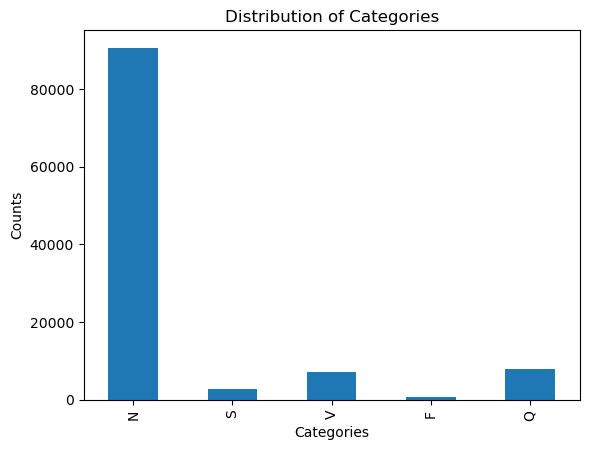

In [18]:
classes_data = {0: 'N', 1: 'S', 2: 'V', 3: 'F', 4: 'Q'}

value_counts.index = value_counts.index.map(classes_data)
value_counts.plot.bar()

plt.title('Distribution of Categories')
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.show()

### Plot type for Each Beat Type Category

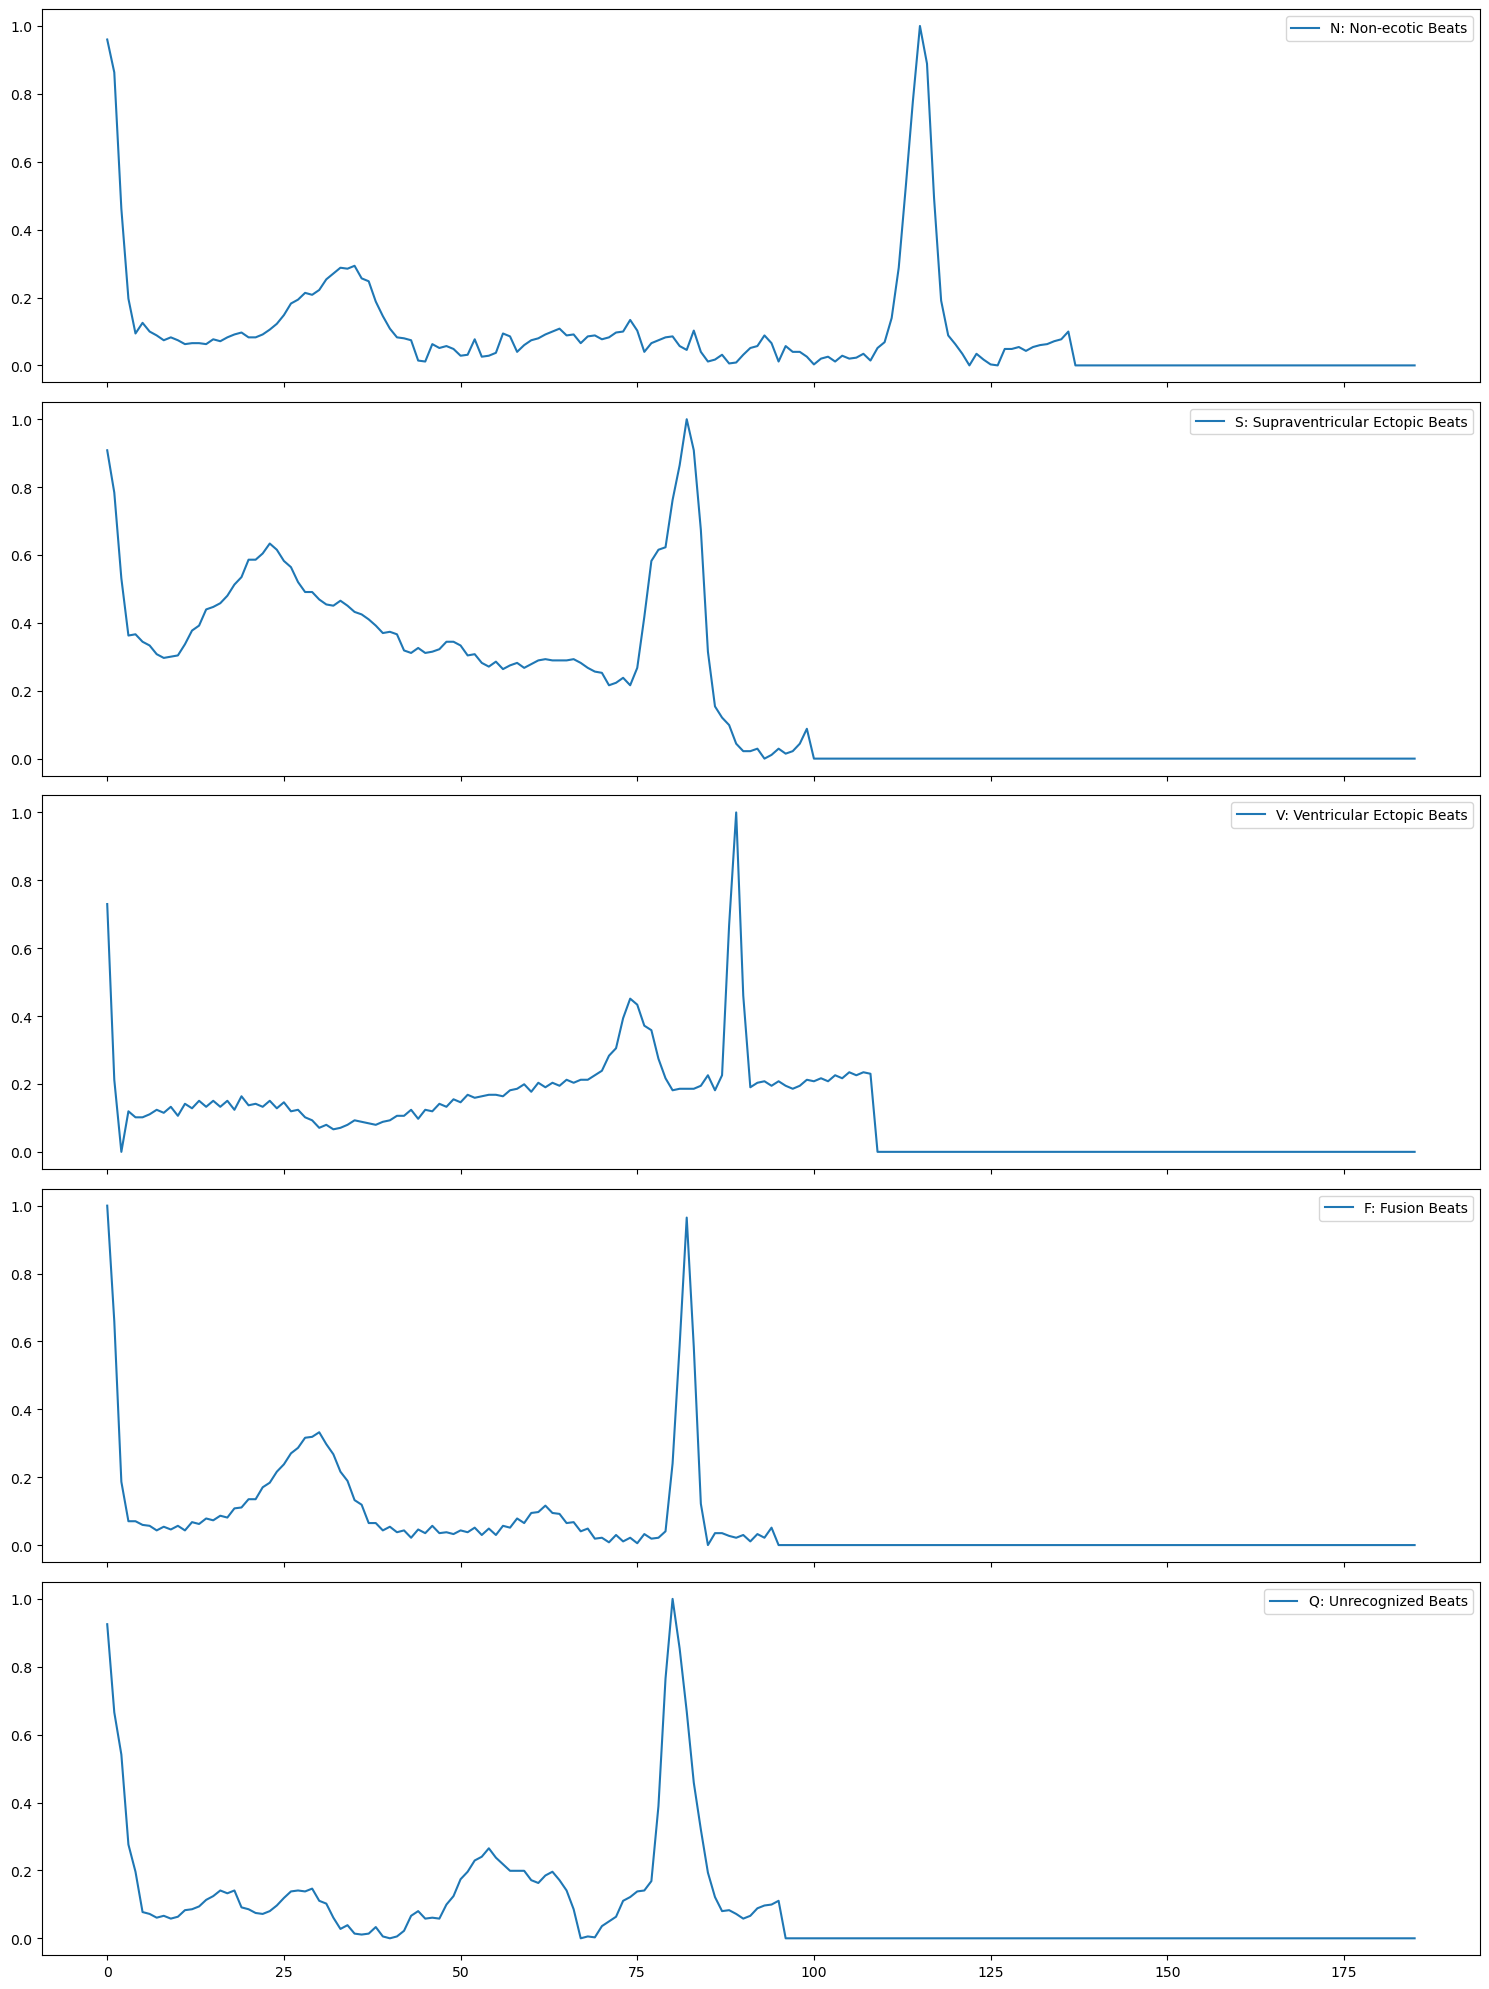

In [21]:
class_names = {
    'N': 'Non-ecotic Beats',
    'S': 'Supraventricular Ectopic Beats',
    'V': 'Ventricular Ectopic Beats',
    'F': 'Fusion Beats',
    'Q': 'Unrecognized Beats'
}

classes_Values = ['N', 'S', 'V', 'F', 'Q']

fig, axs = plt.subplots(5, 1, figsize=(15, 20), sharex=True)
for i in range(5):
    axs[i].plot(merged_data.iloc[i, :186], 
                label=f"{classes_Values[i]}: {class_names[classes_data[i]]}")
    axs[i].legend()

plt.tight_layout()
plt.show()


### Plot the ECG Data

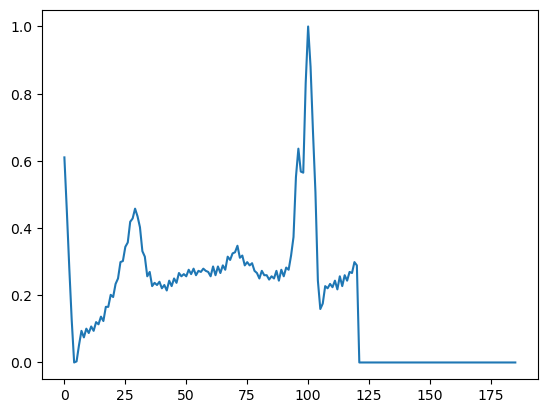

In [22]:
full_dataset = train_dataset.groupby(187, group_keys=False).apply(lambda group: group.sample(1))
ecg_data = full_dataset.iloc[0, :186]
plt.plot(ecg_data)
plt.show()

### Correlation Matrix

In [23]:
correlation_matrix = merged_data.corr()
print(correlation_matrix)

          0         1         2         3         4         5         6    \
0    1.000000  0.776378  0.142679 -0.130664 -0.239683 -0.349048 -0.427406   
1    0.776378  1.000000  0.504395 -0.019388 -0.143027 -0.159431 -0.229312   
2    0.142679  0.504395  1.000000  0.674550  0.405696  0.347716  0.281980   
3   -0.130664 -0.019388  0.674550  1.000000  0.820441  0.596375  0.474312   
4   -0.239683 -0.143027  0.405696  0.820441  1.000000  0.881717  0.750068   
..        ...       ...       ...       ...       ...       ...       ...   
183 -0.039591 -0.013760 -0.031110 -0.042544 -0.015926  0.005693  0.006008   
184 -0.038347 -0.012655 -0.031320 -0.042901 -0.017222  0.003327  0.003493   
185 -0.036756 -0.012079 -0.032765 -0.044554 -0.020802 -0.001065 -0.000440   
186 -0.035825 -0.012031 -0.034089 -0.045437 -0.021704 -0.002451 -0.001697   
187 -0.165683 -0.181525  0.254652  0.509595  0.509319  0.409575  0.327163   

          7         8         9    ...       178       179       180  \
0  

### Model Development

### Adding K-fold Column for Cross-Validation

In [24]:
# creating k-fold column
merged_data.loc[:, 'kfold'] = -1

merged_data = merged_data.sample(frac=1).reset_index(drop=True)

# Extracting Traget Labels
y = merged_data.loc[:, 187].values

kf = StratifiedKFold(n_splits=5)
for fold, (target, index) in enumerate(kf.split(X=merged_data, y=y)):
    merged_data.loc[index, 'kfold'] = fold
    
merged_data.head()

0         1         2         3         4         5         6  \
0  1.000000  0.961006  0.699371  0.452830  0.403774  0.343396  0.318239   
1  0.946721  0.797131  0.047131  0.000000  0.012295  0.022541  0.077869   
2  0.976445  0.946467  0.678801  0.314775  0.197002  0.190578  0.139186   
3  0.997525  0.944307  0.881188  0.814356  0.730198  0.660891  0.529703   
4  1.000000  0.831461  0.303371  0.030899  0.053371  0.064607  0.016854   

          7         8         9  ...  179  180  181  182  183  184  185  186  \
0  0.294340  0.293082  0.275472  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.090164  0.102459  0.096311  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.109208  0.117773  0.109208  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.434406  0.314356  0.238861  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.014045  0.014045  0.019663  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   187  kfold  
0  2.0      0  
1  0.0      0  
2  0.0      0  
3  4.0      0  
4  0.0      0  

[5 rows x 189 columns]

In [25]:
merged_data.head()

0         1         2         3         4         5         6  \
0  1.000000  0.961006  0.699371  0.452830  0.403774  0.343396  0.318239   
1  0.946721  0.797131  0.047131  0.000000  0.012295  0.022541  0.077869   
2  0.976445  0.946467  0.678801  0.314775  0.197002  0.190578  0.139186   
3  0.997525  0.944307  0.881188  0.814356  0.730198  0.660891  0.529703   
4  1.000000  0.831461  0.303371  0.030899  0.053371  0.064607  0.016854   

          7         8         9  ...  179  180  181  182  183  184  185  186  \
0  0.294340  0.293082  0.275472  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.090164  0.102459  0.096311  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.109208  0.117773  0.109208  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.434406  0.314356  0.238861  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.014045  0.014045  0.019663  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   187  kfold  
0  2.0      0  
1  0.0      0  
2  0.0      0  
3  4.0      0  
4  0.0      0  

[5 rows x 189 columns]

0-fold trained



Epoch 1/10


2737/2737 [==============================] - 102s 36ms/step - loss: 0.3725 - accuracy: 0.8941 - auc: 0.9787 - val_loss: 0.1951 - val_accuracy: 0.9409 - val_auc: 0.9932
Epoch 2/10
2737/2737 [==============================] - 92s 33ms/step - loss: 0.1971 - accuracy: 0.9475 - auc: 0.9915 - val_loss: 0.1526 - val_accuracy: 0.9574 - val_auc: 0.9952
Epoch 3/10
2737/2737 [==============================] - 93s 34ms/step - loss: 0.1646 - accuracy: 0.9565 - auc: 0.9935 - val_loss: 0.1327 - val_accuracy: 0.9624 - val_auc: 0.9957
Epoch 4/10
2737/2737 [==============================] - 96s 35ms/step - loss: 0.1441 - accuracy: 0.9618 - auc: 0.9946 - val_loss: 0.1215 - val_accuracy: 0.9680 - val_auc: 0.9957
Epoch 5/10
2737/2737 [==============================] - 92s 34ms/step - loss: 0.1295 - accuracy: 0.9658 - auc: 0.9955 - val_loss: 0.1101 - val_accuracy: 0.9699 - val_auc: 0.9965
Epoch 6/10
2737/2737 [==============================] - 99s 36ms/step - loss: 0.1186 - ac

C:\Users\sreem\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


685/685 [==============================] - 10s 14ms/step - loss: 0.0943 - accuracy: 0.9752 - auc: 0.9972
Accuracy Value (Fold 0): 97.52%
AUC Value (Fold 0): 0.9972
1-fold trained
Epoch 1/10
2737/2737 [==============================] - 98s 34ms/step - loss: 0.3672 - accuracy: 0.8993 - auc: 0.9792 - val_loss: 0.1864 - val_accuracy: 0.9454 - val_auc: 0.9934
Epoch 2/10
2737/2737 [==============================] - 91s 33ms/step - loss: 0.1947 - accuracy: 0.9485 - auc: 0.9916 - val_loss: 0.1908 - val_accuracy: 0.9496 - val_auc: 0.9932
Epoch 3/10
2737/2737 [==============================] - 87s 32ms/step - loss: 0.1643 - accuracy: 0.9573 - auc: 0.9934 - val_loss: 0.1305 - val_accuracy: 0.9627 - val_auc: 0.9955
Epoch 4/10
2737/2737 [==============================] - 94s 34ms/step - loss: 0.1411 - accuracy: 0.9622 - auc: 0.9948 - val_loss: 0.1175 - val_accuracy: 0.9681 - val_auc: 0.9956
Epoch 5/10
2737/2737 [==============================] - 90s 33ms/step - loss: 0.1256 - accuracy: 0.9660 - auc

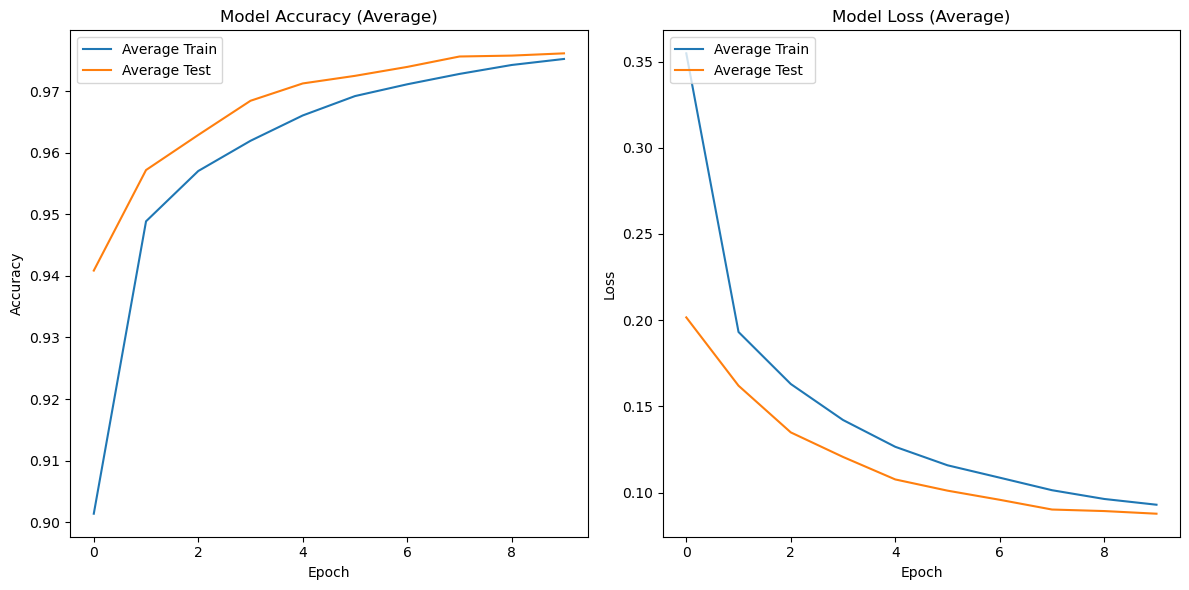

{'Fold 0': 'Accuracy Value: 97.52', 'Fold 1': 'Accuracy Value: 97.79', 'Fold 2': 'Accuracy Value: 97.58', 'Fold 3': 'Accuracy Value: 97.93', 'Fold 4': 'Accuracy Value: 97.26'}


In [26]:
# Define Batch_size and Epochs
Batch_size = 32
Epochs = 10
n_folds = 5

all_train_acc = []
all_test_acc = []
all_train_loss = []
all_test_loss = []

acc_val = {}

# Perform k-fold cross-validation
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(kf.split(merged_data)):
    print(f"{fold}-fold trained")

    train = merged_data.iloc[train_idx].reset_index(drop=True)
    test = merged_data.iloc[test_idx].reset_index(drop=True)

    # Extract features and target from the training and validation sets
    X_train_data = np.asarray(train.iloc[:, :187].values)
    y_train_data = train.iloc[:, 187].values
    X_test_data = np.asarray(test.iloc[:, :187].values)
    y_test_data = test.iloc[:, 187].values

    X_train_data = np.expand_dims(X_train_data, axis=2)
    X_test_data = np.expand_dims(X_test_data, axis=2)

    y_train_data = to_categorical(y_train_data)
    y_test_data = to_categorical(y_test_data)

    # Model architecture
    model = Sequential()
    model.add(Convolution1D(32, 5, activation='relu', input_shape=(187, 1)))
    model.add(Convolution1D(64, 5, activation='relu'))
    model.add(MaxPooling1D(3))
    model.add(Convolution1D(128, 3, activation='relu'))
    model.add(Convolution1D(256, 3, activation='relu'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(5, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

    # Training
    history = model.fit(X_train_data, y_train_data, validation_data=(X_test_data, y_test_data), batch_size=Batch_size, epochs=Epochs)
    model.save(f'model{fold}.h5')

    all_train_acc.append(history.history['accuracy'])
    all_test_acc.append(history.history['val_accuracy'])
    all_train_loss.append(history.history['loss'])
    all_test_loss.append(history.history['val_loss'])

    output_result = model.evaluate(X_test_data, y_test_data)
    print(f"Accuracy Value (Fold {fold}): {output_result[1] * 100:.2f}%")
    print(f"AUC Value (Fold {fold}): {output_result[2]:.4f}")

    acc_val[f"Fold {fold}"] = f"Accuracy Value: {output_result[1] * 100:.2f}"

average_train_acc = np.mean(all_train_acc, axis=0)
average_test_acc = np.mean(all_test_acc, axis=0)
average_train_loss = np.mean(all_train_loss, axis=0)
average_test_loss = np.mean(all_test_loss, axis=0)

plt.figure(figsize=(12, 6))

# Plot average training & testing accuracy values
plt.subplot(1, 2, 1)
plt.plot(average_train_acc)
plt.plot(average_test_acc)
plt.title('Model Accuracy (Average)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Average Train', 'Average Test'], loc='upper left')

# Plot average training & testing loss values
plt.subplot(1, 2, 2)
plt.plot(average_train_loss)
plt.plot(average_test_loss)
plt.title('Model Loss (Average)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Average Train', 'Average Test'], loc='upper left')

plt.tight_layout()
plt.show()

print(acc_val)

In [27]:
# Loading and using the best model
best_model = tf.keras.models.load_model('model3.h5')
best_model.summary()

y_prediction = best_model.predict(X_test_data)
print(y_prediction)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 183, 32)           192       
                                                                 
 conv1d_13 (Conv1D)          (None, 179, 64)           10304     
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 59, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_14 (Conv1D)          (None, 57, 128)           24704     
                                                                 
 conv1d_15 (Conv1D)          (None, 55, 256)           98560     
                                                                 
 global_average_pooling1d_3  (None, 256)               0         
  (GlobalAveragePooling1D)                            

### Confusion Matrix

Normalized confusion matrix


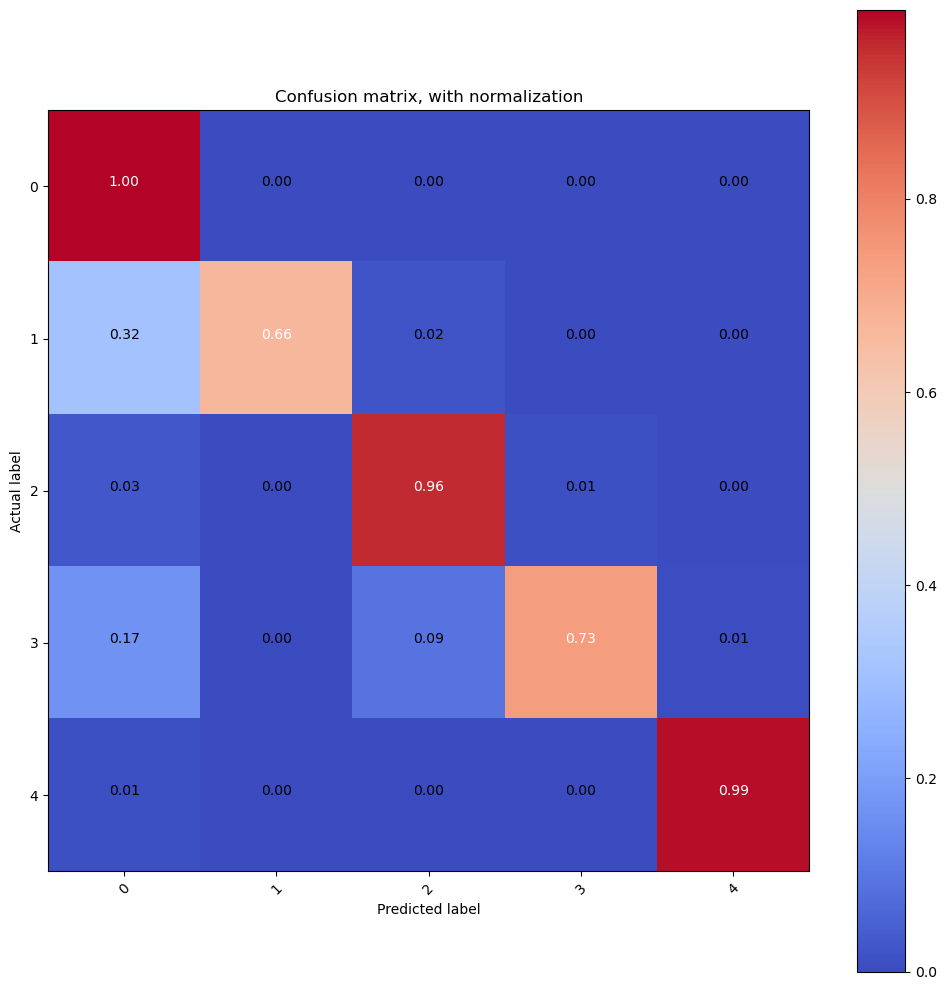

In [28]:
cnf_matrix = confusion_matrix(y_test_data.argmax(axis=1), y_prediction.argmax(axis=1))
np.set_printoptions(precision=2)

plt.figure(figsize=(10, 10))

normalize = True

if normalize:
    cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
else:
    print('Confusion matrix, without normalization')

cmap = 'coolwarm'

plt.imshow(cnf_matrix, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix, with normalization' if normalize else 'Confusion matrix, without normalization')
plt.colorbar()

tick_marks = np.arange(len(classes_data))
plt.xticks(tick_marks, classes_data, rotation=45)
plt.yticks(tick_marks, classes_data)

fmt = '.2f' if normalize else 'd'
thresh = cnf_matrix.max() / 2.

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    text_color = "white" if cnf_matrix[i, j] > thresh else "black"
    plt.text(j, i, format(cnf_matrix[i, j], fmt),
             horizontalalignment="center",
             color=text_color)

plt.tight_layout()
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()